# Contexte
Ton ancien collègue Bernardo t'appelle. Il est très inquiet. Son ordinateur est cassé et il n'avait aucune sauvegarde.

Il l'avait posé sur une table, et le vent l'a fait tombé. Il te l'a déjà dit 100 fois : le vent trop fort ne fait que du tort à son activité.

Bernardo gère les stocks de 4 boutiques. Il avait l'habitude de prévoir les ventes des prochaines semaines pour commander ses nouveaux stocks.

Il vient juste de retrouvé un ancien fichier, avec les volumes de ventes de l'année 2019 d'une seule boutique, mais il ne sait pas laquelle. Il se rappelle que tu es le Zorro de la data. Il t'appelle donc à la rescousse.

# Attendu

1. Analyse descriptive exploratoire (EDA)<br>
Tu commenceras par explorer les données de vente (fichier ici), et tu mettras en avant notamment les saisonnalités, les produits et la complétude des données.

2. Trouver la boutique correspondante<br>
Tu détermineras à quelle boutique correspond ce fichier de ventes. Pour cela, tu pourras t'aider de données météo. En effet, Bernardo nous a indiqué que les ventes sont corrélées à la météo.
Les boutiques se situent à Bordeaux, Lille, Lyon et Marseille. Tu trouveras les historiques de météo ici pour Bordeaux, Lille, Lyon, et Marseille.

3. Explication de l'impact de la météo<br>
Tu détermineras (par corrélation, ou par Machine Learning) l'importance de chaque dimension. Tu mettras en avant les variables (température, vitesse du vent, etc...) qui semblent les plus corrélées aux ventes, et celles qui sont le moins corrélées. Bernardo a-t-il raison : est-ce bien le vent qui a le plus d'impact sur les ventes ?

4. Prévisions de ventes<br>
Bernardo a récupéré des prévisions météo sur une semaine (le fichier est ici). Il aimerait que tu lui fasses une prévision des ventes correspondant à cette période, pour qu'il puisse acheter les bons stocks de produit. Tu devras donc indiquer le stock total minimum que tu conseilles à Bernardo de commander pour la semaine prochaine, afin de pouvoir répondre à la demande, sans faire des sur-stocks.

# Initialisation du projet

## Import des librairies

In [1]:
# Analyse descriptive
import pandas as pd
from datetime import datetime, timedelta, timezone
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
from IPython.display import display
from termcolor import colored
from scipy.stats import bartlett, shapiro, spearmanr
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import *

# Prédiction
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression,  Ridge, ElasticNet, Lasso
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV




import statistics as stats
import math



## Paramètres

In [2]:
%matplotlib inline 
# On indique que l'on veut voir apparaître les graphiques dans le notebook, sinon on ne verrait rien

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 22)

## Import des fichiers

In [3]:
path='./Fichiers/'
forecast=pd.read_csv(path+"forecast.csv")
marseille=pd.read_csv(path+"marseille2019.csv", sep=",",skiprows = 3)
lyon=pd.read_csv(path+"lyon2019.csv", sep=",",skiprows = 3)
bordeaux=pd.read_csv(path+"bordeaux2019.csv", sep=",",skiprows = 3)
lille=pd.read_csv(path+"lille2019.csv", sep=",",skiprows = 3)
sales=pd.read_csv(path+"history.csv")

## Variables

In [4]:
items_color={'A':'skyblue', 'B':'hotpink'} # 2 couleurs pour les produits
alpha = 0.05 # pour les différents tests statistiques, valeur du seuil

## Fonctions

In [5]:
def create_moving_average (df, rolling_number) :
    '''
Add a moving_average column in dataframe

Parameters
----------
    - df : the dataframe to add the column in
    - rolling_number : the value of moving average
    '''
    
    moving_average = df.sales.rolling(rolling_number, center=True).mean()
    df["moving_average"] = moving_average


In [6]:
def plot_moving_average (df_moving_avg, df, product) :
    
    '''
Plot the moving average v. reals sales

Parameters
----------
    - dataframe containing moving average data
    - original dataframe
    - product to plot
    
Return
------
The graph to plot
    '''
    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df_moving_avg.query("item==@product"), x="date",y='moving_average',linestyle='solid', color="skyblue")
    sns.lineplot(data=df.query("item==@product"), x="date",y='sales', linestyle=":", color="hotpink")
    plt.legend(["Moyenne mobile des ventes","Total des ventes"])
    plt.xlabel("Moyenne mobile")
    plt.ylabel("Date")
    plt.title(f"Evolution des ventes pour le produit {product}")
    plt.show()
    plt.close()


In [7]:

def plot_product_sales (dataframe, x, y, title=None, x_title=None, y_title=None, style=None) :
    '''
Plot the sales by product
Parameters
----------
 - dataframe
 - x = abcissa data
 - y = ordinate data
 - title : the title of the graph
 - x_title : abcissa name
 - y_title : ordinate name
 - style : line style

Returns
-------
The graph to plot
    '''
    
    if style is None:
        style='linear'
    
    fig=px.line(
        data_frame=dataframe.query("item in ['A','B']"), 
        x=x, 
        y=y,
        title=title, color="item",
        color_discrete_map=items_color,
        width=1080, 
        height=720,
        line_shape=style
    ).update_layout(xaxis={"title": x_title}, yaxis={"title": y_title})

    fig.update_xaxes(showspikes=True)
    fig.update_yaxes(showspikes=True)
    fig.show()

In [8]:
def plot_sales_by_weather(df, color_type):
    '''
    Parameters :
    -----------
    - the dataframe to plot
    - color_type : determines the color of box plot : "item" if we have the 2 products, "opinion" for the whole sales
    
    Return :
    ------
    A boxplot graph
    '''
    
    fig = px.box(
        data_frame=df,#.query("item in ['A','B']"),
        x="sales",
        y="opinion",
        width=1080, 
        height=720,
        color=color_type,
        title="Vente par type de météo",
        category_orders={"opinion": order_opinion_list},
    )
    fig.show()


In [9]:
def opinion_encoder(df):
    '''
    Encode la variable qualitative météo en une variable quantitative ordinale
    Parameters
    ----------
    - Prend le dataframe à convertir en entrée
    
    Return
    ------
    La donnée encodée au format int.
    '''
    dict_opinion ={
        'météo très défavorable' :0,
        'météo défavorable':1,
        'météo correcte':2,
        'météo favorable':3,
        'météo idéale':4
    }  

    for i in range(len(df)):
        if df.opinion.loc[i] in dict_opinion.keys():
            df.loc[i,"opinion"] = (dict_opinion.get(df.loc[i,"opinion"]))

    df.opinion = df.opinion.astype(int)

In [10]:
def plot_var_with_sales(df, item) :
    ''' 
    Pairplot par produit
    Parameters 
    ----------
    - df = dataframe
    - item = product
    
    Return
    ------
    pairplot by broduct
    '''
    sns.set(font_scale=2)
    sns.pairplot(
        data=df,
        x_vars=['max_temperature_c', 'min_temperature_c', 'windspeed_max_kmh',
           'temperature_morning_c', 'temperature_noon_c', 'temperature_evening_c',
           'precip_total_day_mm', 'humidity_max_percent', 'visibility_avg_km',
           'pressure_max_mb', 'cloudcover_avg_percent', 'heatindex_max_c',
           'dewpoint_max_c', 'windtemp_max_c', 'total_snow_mm', 'uv_index',
           'sunhour',],
        y_vars=["sales"],
        height=4
    )

    plt.suptitle(
        ("Relation entre les variables explicatives et prédictive pour le produit " + item ),
        y=1.1,
         fontsize = 'x-large' , 
         fontweight = 'bold',
         va = "center",
         ha="center"
    )

    plt.show()
    plt.close()

In [11]:
def plot_corr_matrix(df_corr) :
    
    mask = np.triu(np.ones_like(df_corr, dtype=bool),k=1)

    plt.figure(figsize=(10,10))
    sns.heatmap(
        df_corr, 
        cmap = 'RdBu_r', 
        mask=mask,
        annot=True,
        center=0,
        vmin=-1,
        vmax=1,
        fmt=".2f", 
        linewidths=1,
        annot_kws={"size":8},
    )

    plt.title("Matrice de corrélation de Spearman", fontsize=20, loc='center', pad=20)

    plt.show()
    plt.close()

In [12]:
def select_best_model(dict_of_models, X_train, X_test, y_train, y_test) :
    '''
    Fonction pour sélectionner le meilleur estimateur sans paramétrage.
    Paramètres
    ----------
    Prend le dictionnaire de mes modèles en entrée et les données échantillonnées
    
    Return
    ------
    Affiche le score r2 de chaque modèle
    Retourne le meilleur modèle
    '''
    score=0
    best_model=""

    for name, model in dict_of_models.items():
        model.fit(X_train, y_train)  
        
        y_pred = model.predict(X_test)
        print (name, ': r2_score = ', np.round(r2_score(y_test, y_pred),4))
        if np.round(r2_score(y_test, y_pred),4) >= score:
            score = r2_score(y_test, y_pred)
            best_model = name

    print (f"""
Le meilleur modèle est {best_model}.""")  
  

In [130]:
def number_of_combination(dictionary_param, number_of_split, longtime=None):
    """
    Cette fonction est utilisée pour calculer le nombre de combinaison
    défini des GridSearch pour optimiser les paramtètres des modèles. 
    Parameters
    ----------
    - dictionary_param : dictionnaire de paramètres à tester
    - number_of_split : le nombre de cross validation qu'on veut
    - longtime : si le calcul est long, mettre "y"
    Return
    ------
    Le nombre de combinaison ainsi que la durée prévue d'exécution
    """
    from numpy import prod
    lengths = [len(v) for v in dictionary_param.values()]
    count = prod(lengths)
    print(f"Il y a {count} combinaisons à tester sur {number_of_split} cross-validation, soit {count * number_of_split} possibilités.")

    if longtime == "y" :
        # Estimation du temps de traitement
        current_time = datetime.now()
        runtime = count * 0.05 * number_of_split # J'estime à 0.025 seconde la moyenne d'exécution de chaque combinaison avec n_jobs en illimité (-1)
        time_to_process = timedelta(seconds=runtime) 
        end_date = (current_time + time_to_process).strftime("%d/%m/%Y")
        end_time = (current_time + time_to_process).strftime("%H:%M:%S")

        if runtime < 60:
            return print("Ca devrait être terminé dans moins d' 1 minute ;-)")
        elif runtime < 600:
            return print(f"Tu peux faire une petite pause, l'apprentissage devrait se terminer le {end_date} vers {end_time}.")
        elif runtime < 1200:
            return print(f"Oula! Ca risque d'être un peu long, tu peux répondre à tes mails pendant l'apprentissage ou faire un Sit'n'Go, fin estimée le {end_date} vers {end_time}.")
        elif runtime < 3600:
            return print(f"Oula! Ca risque d'être un peu long, tu peux partir manger (sauf si ce n'est pas l'heure!) fin estimée le {end_date} vers {end_time}.")                                              
        else:
            return print(f"Tu peux mettre ton PC en veille et revenir demain ! Fin estimée le {end_date} vers {end_time}.")


In [102]:
def data_sampling(X, y):
    '''
    Je sépare mon dataframe en 2 : variables explicatives d'un côté, variable à prédire de l'autre.
    Parameters
    ----------
    Mon jeu de données séparé, X et y
    
    Return
    ------
    4 jeux de données X_train, X_test, y_train, y_test
    '''

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=True)
    print (f"""Le jeu de données d'entraînement contient {X_train.shape[0]} lignes.
Le jeu de test en contient {X_test.shape[0]}.""")
    return X_train, X_test, y_train, y_test


In [143]:
def display_scores(y_true,y_pred):
    '''
    Return score : mean_squared_error, mean_squared_log_error, r2_score, mean_absolute_error, median_absolute_error
    Parameters : 
        - y_true
        - y_pred
    Returns the different scores
    '''
    
    rmse =  mean_squared_error(y_true, y_pred,squared=False)*0.3 #on peut multiplier par 0.3 pour avoir un résultat en mètre
    r2 = r2_score(y_true, y_pred)
    meanae = mean_absolute_error(y_true,y_pred)
    medae = median_absolute_error(y_true,y_pred)

    # Affichage des valeurs
    print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
    print("Moyenne absolue des erreurs :", meanae)
    print("Log de la médiane absolue des erreurs :", medae)
    print(f"""Le coefficient de détermination (Score R² de précision) vaut: {r2:.2f}.""")
    

In [234]:

def render_mpl_table(data, title,colLabels, col_width=3.0, row_height=0.625, font_size=14,
header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',bbox=[0, 0, 1, 1], header_columns=0):
    import six
    """
    Dataframe configuration function for export -> retrieved from internet
    Params = dataframe, title, name of columns and setting up.
    """
    size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
    fig, ax = plt.subplots(figsize=size)
    ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=colLabels)
    #mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    plt.ioff()
    plt.savefig(title+".png", dpi=200)
    plt.show()
    plt.close()

# 1. Analyse descriptive exploratoire

## Qualité des données

In [14]:
sales

DATE ITEM  SALES
0    02-01-2019    A    113
1    03-01-2019    A    143
2    04-01-2019    A    145
3    05-01-2019    A    167
4    06-01-2019    A    202
..          ...  ...    ...
515  25-12-2019    B     96
516  26-12-2019    B     85
517  27-12-2019    B     87
518  28-12-2019    B     79
519  29-12-2019    B     76

[520 rows x 3 columns]

### Conversion des données

Par commodité, je passe le nom des colonnes en minuscule

In [15]:
sales.columns = sales.columns.str.lower()
sales

date item  sales
0    02-01-2019    A    113
1    03-01-2019    A    143
2    04-01-2019    A    145
3    05-01-2019    A    167
4    06-01-2019    A    202
..          ...  ...    ...
515  25-12-2019    B     96
516  26-12-2019    B     85
517  27-12-2019    B     87
518  28-12-2019    B     79
519  29-12-2019    B     76

[520 rows x 3 columns]

In [16]:
sales.dtypes

date     object
item     object
sales     int64
dtype: object

Je convertis l'objet "date" en date

In [17]:
sales.date=pd.to_datetime(sales["date"], format="%d-%m-%Y", )
sales.dtypes

date     datetime64[ns]
item             object
sales             int64
dtype: object

### Détection d'anomalies

In [18]:
sales.describe()

sales
count  520.000000
mean    98.207692
std     61.444707
min      0.000000
25%     48.000000
50%     87.000000
75%    143.000000
max    282.000000

In [19]:
sales.nunique()

date     260
item       2
sales    185
dtype: int64

**Note**<br>
Il  n'y a que 2 types de produits et pas d'erreur de données notables dans l'observation du describe.<br>
Nous avons 260 dates sur 365 jours dans l'année.

### Valeurs nulles

Je regarde s'il y a des valeurs nulles ou valant 0.

In [20]:
print (f" Il y a {sales.isnull().sum().sum()} produit(s) ayant une valeur nulle.")

 Il y a 0 produit(s) ayant une valeur nulle.


In [21]:
no_sales=sales[sales.loc[:,"sales"]==0]
total_no_sales = no_sales["sales"].count()
print (f"Il y a {total_no_sales} jours sans aucune vente.")

Il y a 23 jours sans aucune vente.


In [22]:
print (f"Les produits concernés par l'absence de vente sont :")
for i in no_sales.item.unique():
    print (f"- Produits {i}")

Les produits concernés par l'absence de vente sont :
- Produits B


### Imputation des valeurs manquants

Je vais remplacer les valeurs manquantes pour faciliter ensuite les divers traitements.<br>
Je ne peux pas appliquer la méthode KNNimputer car je n'ai pas que des variables numériques.<br>
Je vais imputer par la fonction d'interpolation linéaire.

Je regarde la distribution des ventes avant imputation

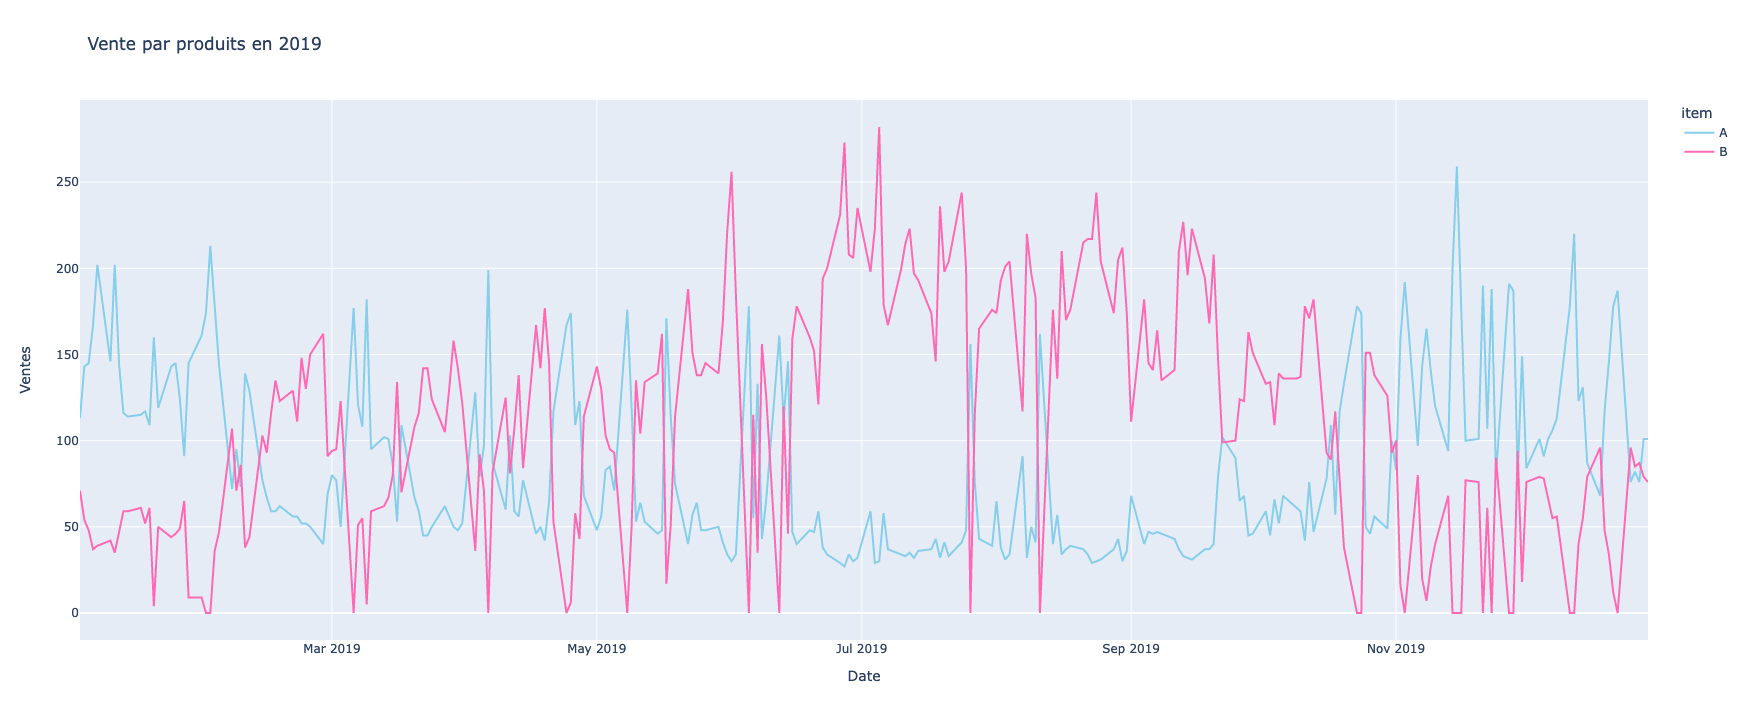

In [23]:
plot_product_sales(dataframe=sales, x='date', y="sales", title="Vente par produits en 2019", x_title="Date", y_title="Ventes")

Pour pouvoir utiliser l'interpolation, je remplace mes 0 par NaN.

In [24]:
sales["sales"].replace(0, np.nan, inplace=True)

In [25]:
sales.isna().sum()

date      0
item      0
sales    23
dtype: int64

Je procède à l'imputation

In [26]:
sales.sales.interpolate(method='linear', inplace=True)
sales.sales = np.ceil(sales.sales).astype(int)

Vérification

In [27]:
sales.iloc[no_sales.index,:]

date item  sales
281 2019-01-31    B     18
282 2019-02-01    B     27
305 2019-03-06    B     87
328 2019-04-06    B     77
340 2019-04-24    B     30
350 2019-05-08    B     72
370 2019-06-05    B    150
375 2019-06-12    B    123
407 2019-07-26    B    158
419 2019-08-11    B    180
470 2019-10-23    B     76
471 2019-10-24    B    114
479 2019-11-03    B     48
486 2019-11-14    B     71
487 2019-11-15    B     73
488 2019-11-16    B     75
491 2019-11-21    B     69
493 2019-11-23    B     76
495 2019-11-27    B     92
496 2019-11-28    B     93
505 2019-12-11    B     51
506 2019-12-12    B     46
514 2019-12-22    B     54

## Analyse des ventes par produit


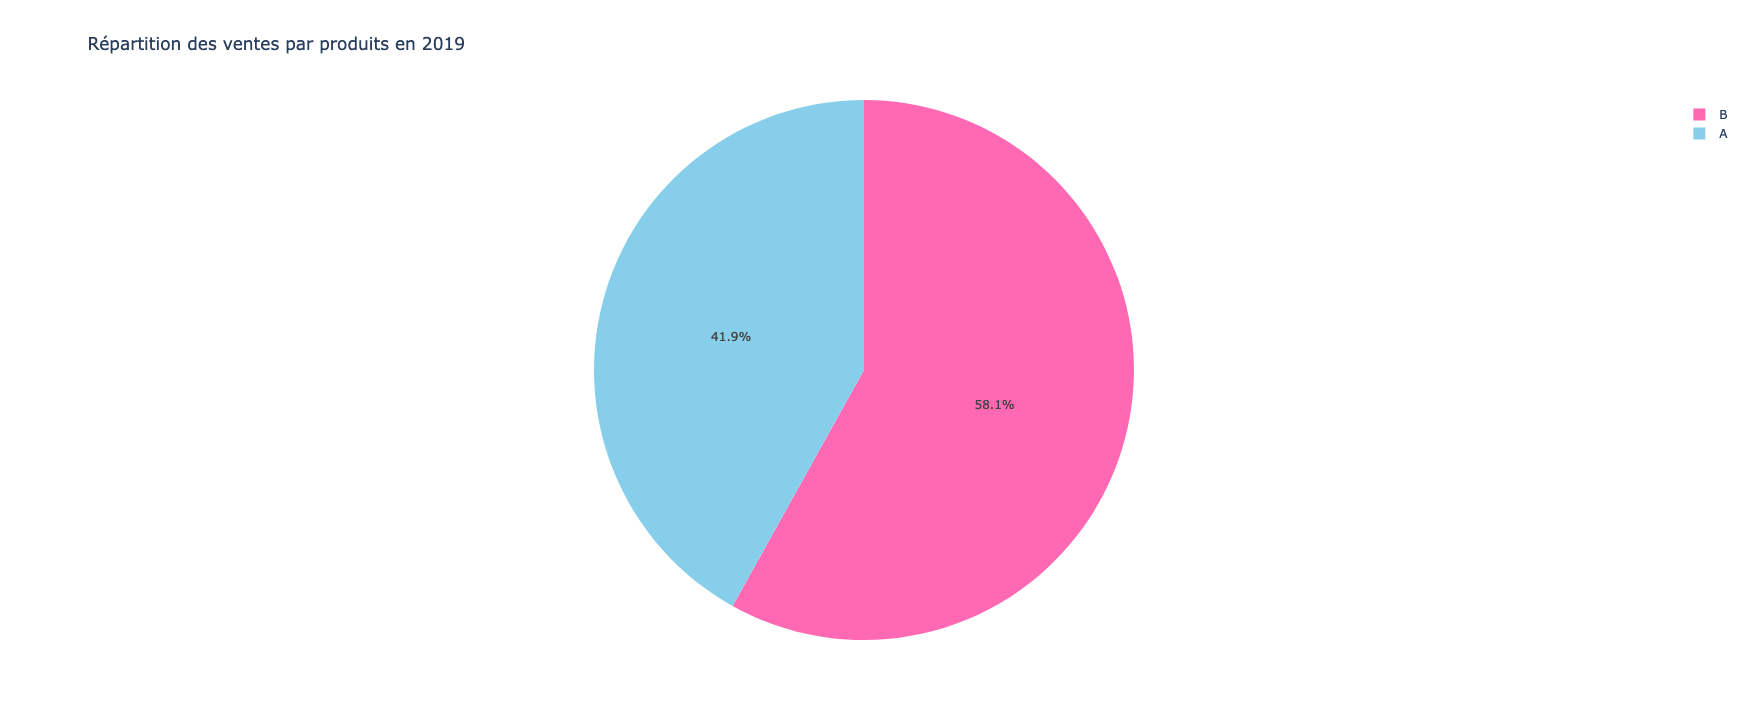

In [28]:
fig = px.pie(data_frame = sales, values="sales", names="item", width=1080, height=720, color = 'item', title="Répartition des ventes par produits en 2019",
             color_discrete_map=items_color)
fig.show()

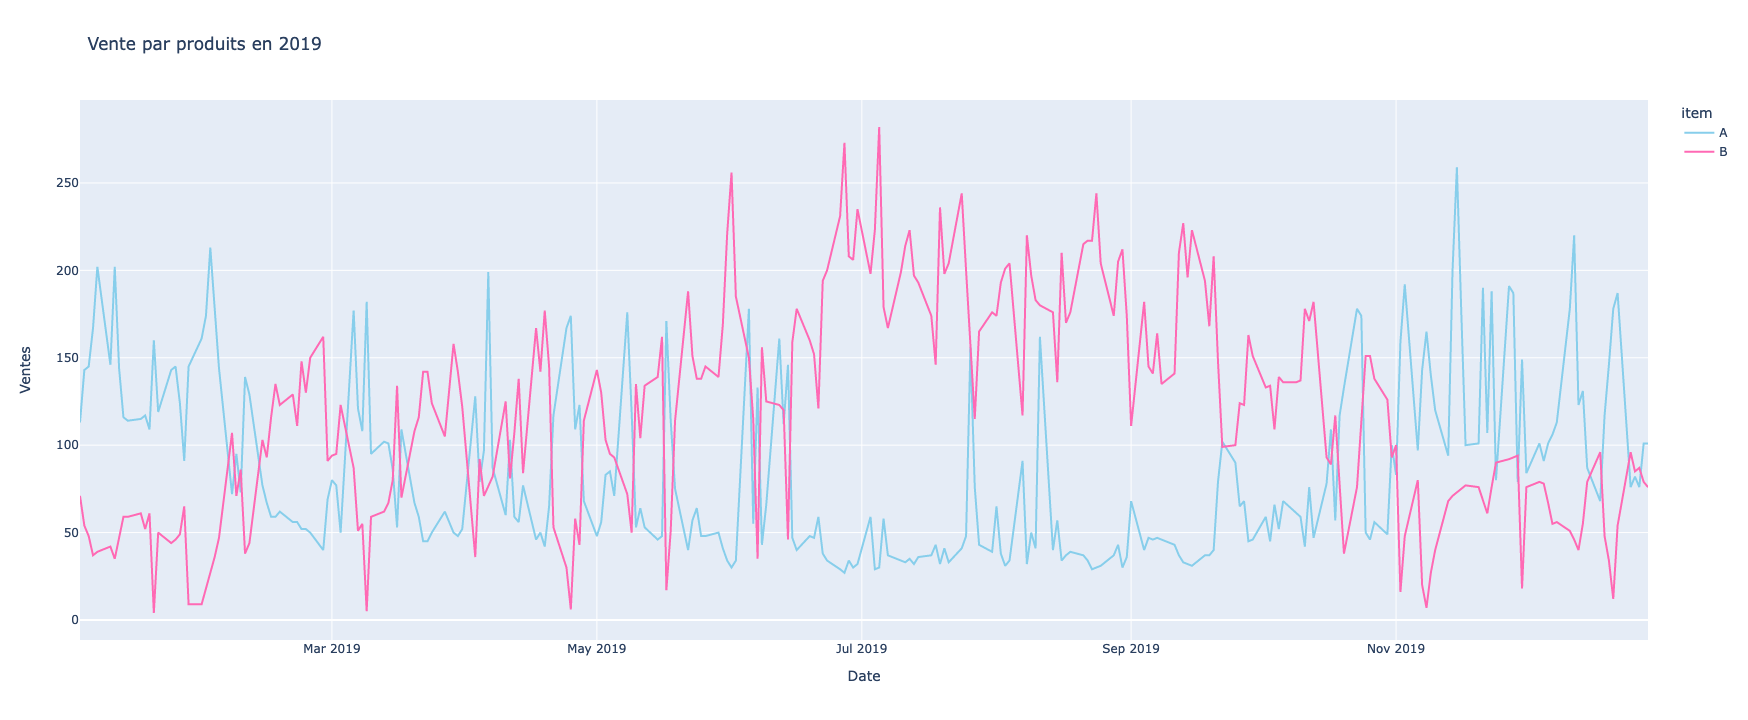

In [29]:
plot_product_sales(dataframe=sales, x='date', y="sales", title="Vente par produits en 2019", x_title="Date", y_title="Ventes")

**Note** <br>
Avec ces 2 graphiques superposés, on peut voir que les 2 produits se complètent : lorsqu'un se vend bien, l'autre non.<br>
Je vais lisser les données par produit pour avoir une tendance de l'évolution de la vente au cours de l'année 2019.

In [30]:
sales_producta = sales[sales.item=='A'].groupby(["date", "item"]).agg({"sales":"sum"}).reset_index()
sales_producta

date item  sales
0   2019-01-02    A    113
1   2019-01-03    A    143
2   2019-01-04    A    145
3   2019-01-05    A    167
4   2019-01-06    A    202
..         ...  ...    ...
255 2019-12-25    A     76
256 2019-12-26    A     82
257 2019-12-27    A     76
258 2019-12-28    A    101
259 2019-12-29    A    101

[260 rows x 3 columns]

In [31]:
sales_productb = sales[sales.item=='B'].groupby(["date", "item"]).agg({"sales":"sum"}).reset_index()
sales_productb

date item  sales
0   2019-01-02    B     71
1   2019-01-03    B     54
2   2019-01-04    B     48
3   2019-01-05    B     37
4   2019-01-06    B     39
..         ...  ...    ...
255 2019-12-25    B     96
256 2019-12-26    B     85
257 2019-12-27    B     87
258 2019-12-28    B     79
259 2019-12-29    B     76

[260 rows x 3 columns]

J'ajoute la colonne de la moyenne mobile

In [32]:
for df in (sales_producta, sales_productb):
    create_moving_average(df ,60)

Je rassemble les 2 dataframes en un seul.

In [33]:
sales_by_product = pd.concat([sales_producta, sales_productb]).reset_index()
sales_by_product

index       date item  sales  moving_average
0        0 2019-01-02    A    113             NaN
1        1 2019-01-03    A    143             NaN
2        2 2019-01-04    A    145             NaN
3        3 2019-01-05    A    167             NaN
4        4 2019-01-06    A    202             NaN
..     ...        ...  ...    ...             ...
515    255 2019-12-25    B     96             NaN
516    256 2019-12-26    B     85             NaN
517    257 2019-12-27    B     87             NaN
518    258 2019-12-28    B     79             NaN
519    259 2019-12-29    B     76             NaN

[520 rows x 5 columns]

J'observe la moyenne mobile par produit puis je compare les 2 courbes.

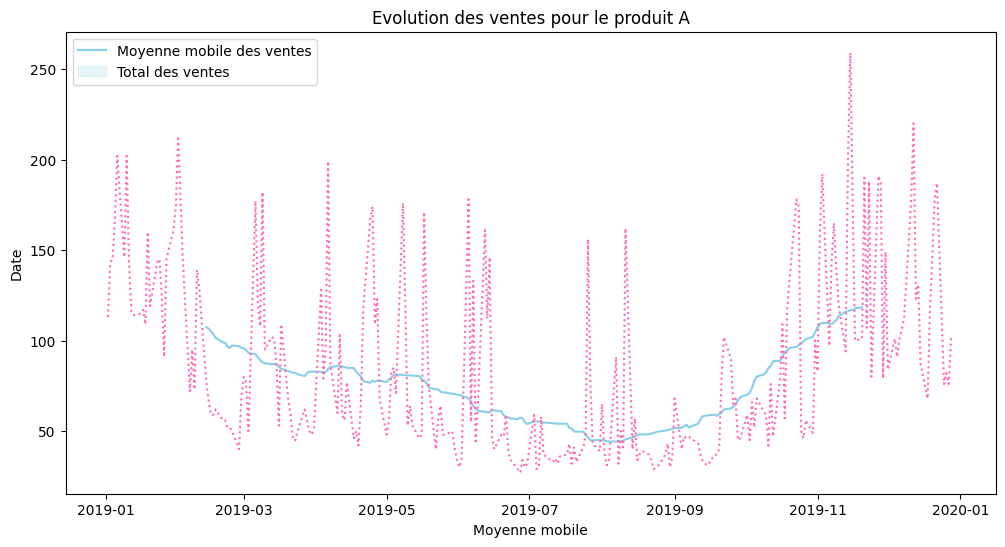

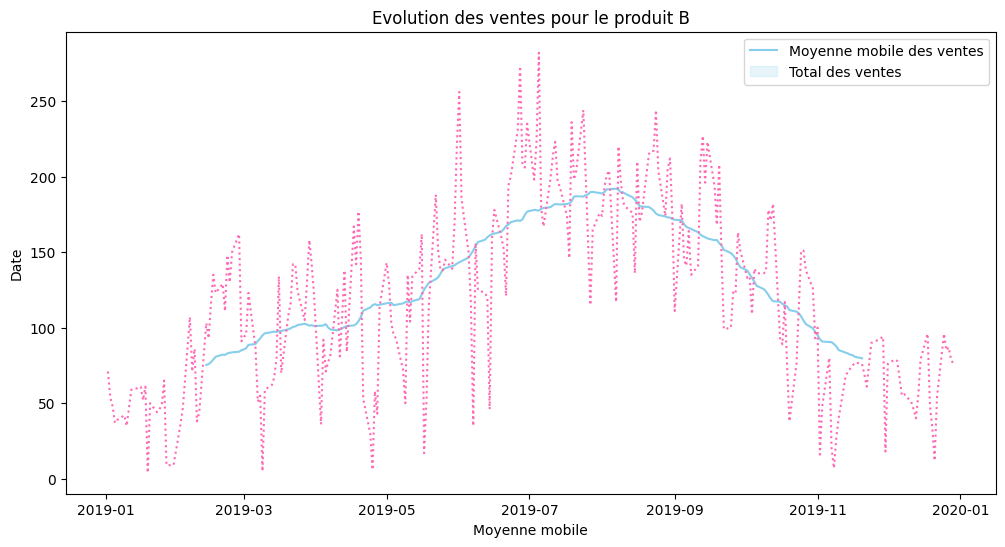

In [34]:
for i in (sales_by_product.item.unique()):
    plot_moving_average(sales_by_product, sales, i)

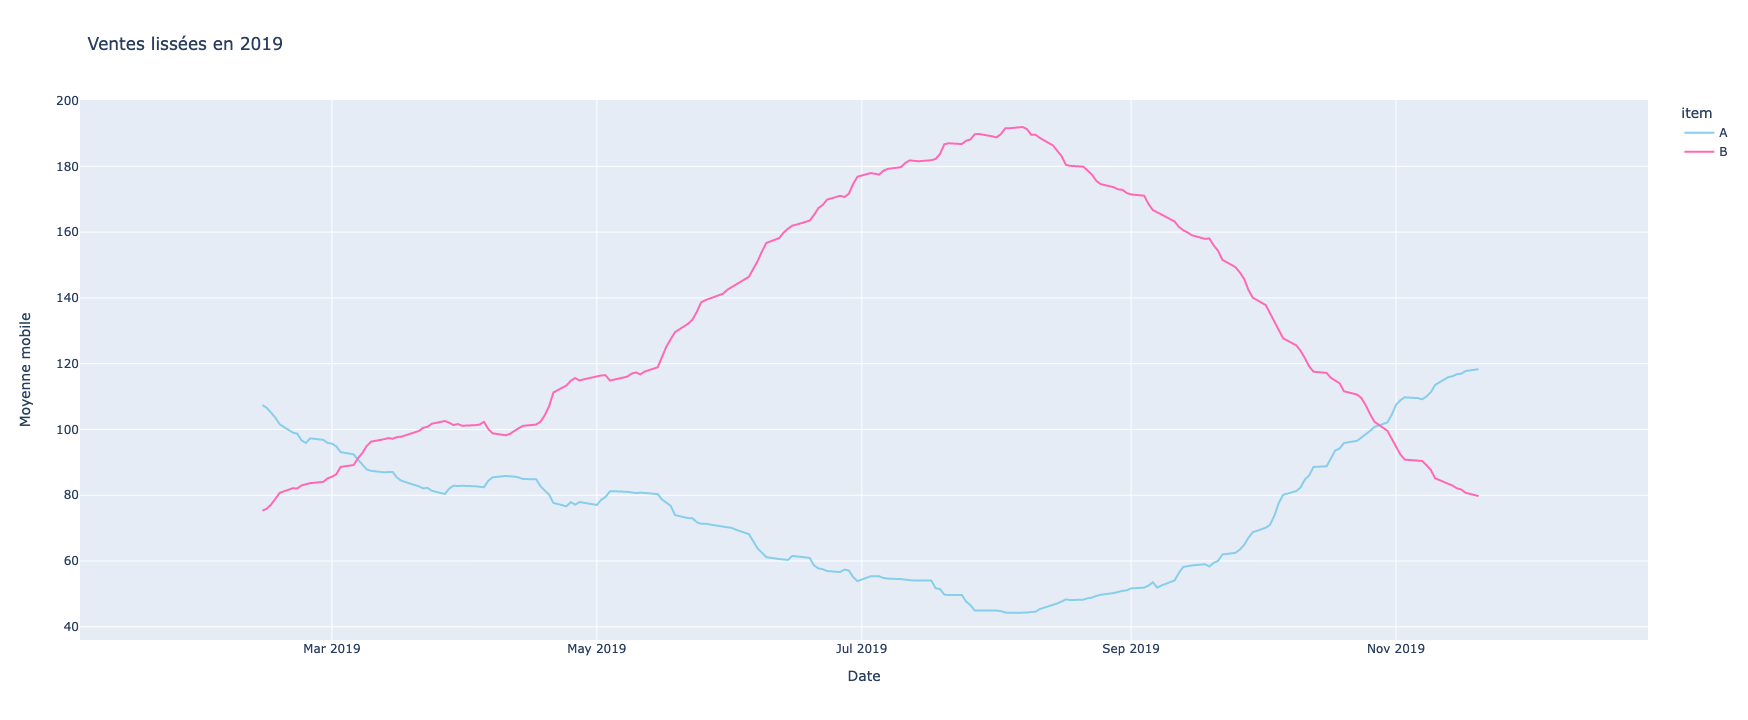

In [35]:
plot_product_sales(dataframe=sales_by_product, x="date", y="moving_average", title="Ventes lissées en 2019", x_title="Date", y_title= "Moyenne mobile")

**Observation**<br>
On confirme l'hypothèse émise plus haut : les produits sont complémentaires, on observe l'inversion des courbes début mars et fin octobre.

Je crée l'indicateur "month" pour suivre l'évolution par mois.

In [36]:
sales_by_product["month"] = sales_by_product.date.dt.month
sales_by_product = sales_by_product.groupby(["item", 'month'], as_index=False).agg(total_per_month=('sales','sum'))
sales_by_product

item  month  total_per_month
0     A      1             3095
1     A      2             1743
2     A      3             1875
3     A      4             1906
4     A      5             1644
5     A      6             1423
6     A      7              972
7     A      8             1058
8     A      9             1079
9     A     10             1722
10    A     11             3201
11    A     12             2467
12    B      1              959
13    B      2             1947
14    B      3             2271
15    B      4             1828
16    B      5             2831
17    B      6             3628
18    B      7             4091
19    B      8             4399
20    B      9             3353
21    B     10             2716
22    B     11             1371
23    B     12             1349

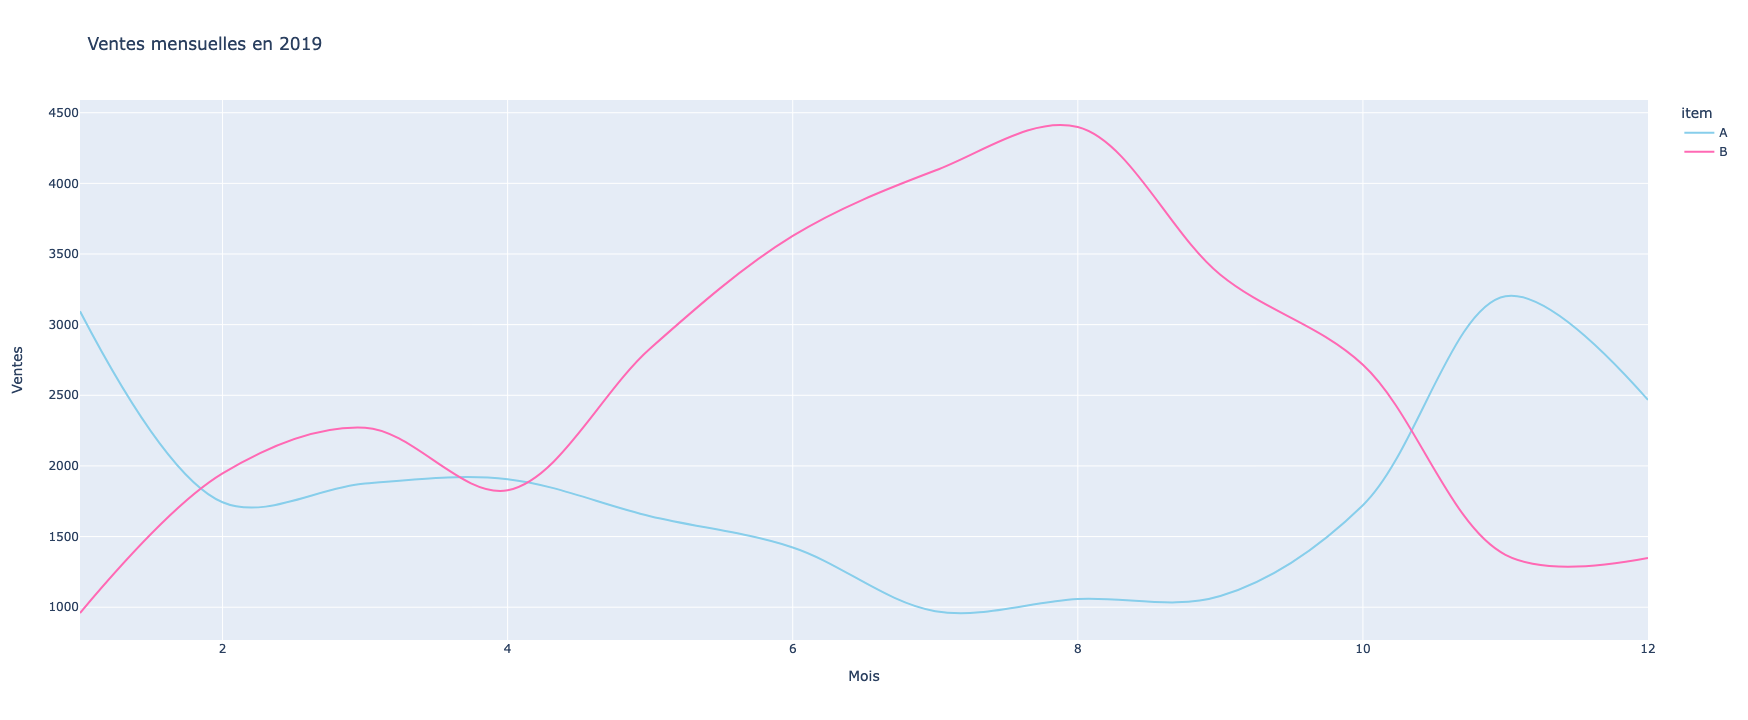

In [37]:
plot_product_sales(dataframe=sales_by_product, x="month", y="total_per_month", title="Ventes mensuelles en 2019", x_title="Mois", y_title= "Ventes", style="spline")

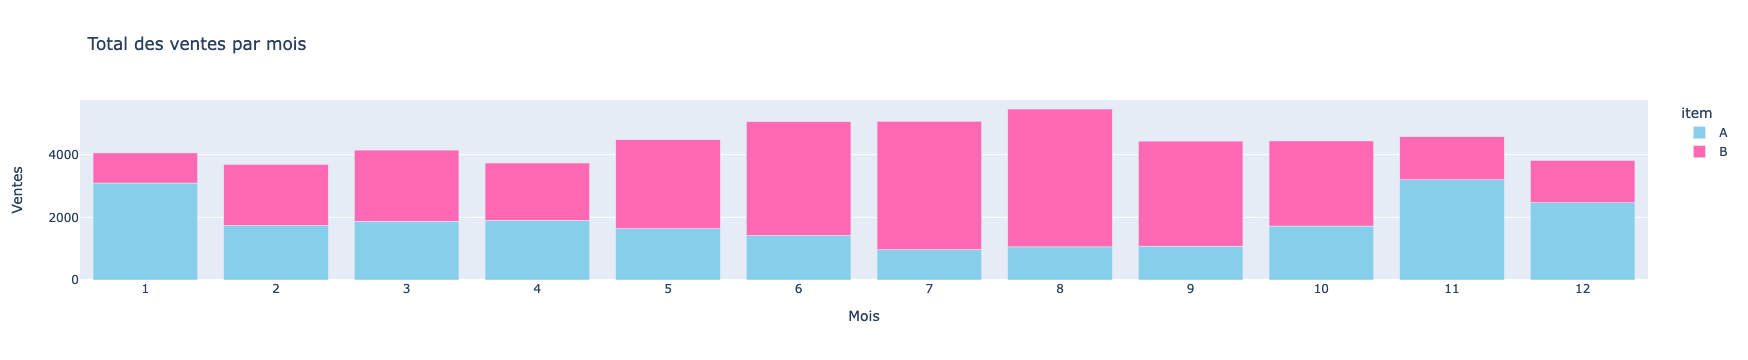

In [38]:
fig = px.bar(sales_by_product, x='month', y='total_per_month', color="item", color_discrete_map=items_color, title="Total des ventes par mois").update_layout(xaxis={"title": "Mois"}, yaxis={"title": "Ventes"})
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
            )
)
fig.show()

## Conclusion

- Il y a 2 **produits** vendus dans la boutiques.
- **Il manque 23 jours de données** sur le produit B : elles ont été remplacées par la moyenne des ventes sur chaque mois.
- Le magasin est fermé 2 jours consécutifs par semaine, le lundi et le mardi.
- On observe une **saisonnalité** des produits : 
    - A est un produit qui se vend mieux en hiver (novembre à janvier)
    - B le reste de l'année

# 2. Trouver la boutique correspondante

D'après Bernardo, "le vent trop fort ne fait que du tort à son activité." <br>
C'est le seul indice pour identifier la boutique. Je vais chercher quelle ville a un vent qui influe sur les ventes.

## Qualité des données

In [39]:
cities = {"lyon":lyon,
          "bordeaux":bordeaux, 
          "lille":lille,
          "marseille":marseille}


In [40]:
for name, df in cities.items() :
    print(colored 
          (f"{name.upper()} - DESCRIPTION DES DONNEES",
           'green',
           attrs=['bold']))
    
    display(df.describe().transpose())
    
    print(colored(
        f"{name.upper()} - TYPE DE DONNEES",
            'green',
            attrs=['bold']))
    print(df.dtypes)
    print("")
    
    print(colored(
        f"{name.upper()} - VALEURS NULLES",
            'green',
            attrs=['bold']))
    print(df.isnull().sum())

    print(f"""
________________________________________________________________________________________________

""")

LYON - DESCRIPTION DES DONNEES


count         mean        std      min       25%  \
MAX_TEMPERATURE_C       365.0    17.808219   8.582594   -1.000    11.000   
MIN_TEMPERATURE_C       365.0    12.813699   7.421629   -4.000     7.000   
WINDSPEED_MAX_KMH       365.0    13.893151   7.580490    3.000     8.000   
TEMPERATURE_MORNING_C   365.0    10.665753   6.631432   -5.000     6.000   
TEMPERATURE_NOON_C      365.0    16.276712   8.126921   -1.000    10.000   
TEMPERATURE_EVENING_C   365.0    15.838356   8.660803   -2.000     9.000   
PRECIP_TOTAL_DAY_MM     365.0     4.173151   8.460158    0.000     0.000   
HUMIDITY_MAX_PERCENT    365.0    71.057534  11.435412   45.000    62.000   
VISIBILITY_AVG_KM       365.0     9.859589   2.124530    2.875     9.125   
PRESSURE_MAX_MB         365.0  1019.808219   7.460256  995.000  1016.000   
CLOUDCOVER_AVG_PERCENT  365.0    43.794863  29.319905    0.000    15.500   
HEATINDEX_MAX_C         365.0    18.235616   9.037428    0.000    11.000   
DEWPOINT_MAX_C          365.0     8.884932   5.559164    0.000     4.000   
WINDTEMP_MAX_C          365.0    11.986301   8.330886   -8.000     6.000   
WEATHER_CODE_MORNING    365.0   157.441096  76.456408  113.000   116.000   
WEATHER_CODE_NOON       365.0   152.246575  69.704750  113.000   116.000   
WEATHER_CODE_EVENING    365.0   163.136986  81.493732  113.000   116.000   
TOTAL_SNOW_MM           365.0     0.045205   0.582162    0.000     0.000   
UV_INDEX                365.0     4.145205   1.755137    1.000     3.000   
SUNHOUR                 365.0     9.650959   3.797820    2.100     6.500   

                           50%      75%     max  
MAX_TEMPERATURE_C         17.0    24.00    39.0  
MIN_TEMPERATURE_C         12.0    18.00    32.0  
WINDSPEED_MAX_KMH         13.0    19.00    45.0  
TEMPERATURE_MORNING_C     10.0    16.00    27.0  
TEMPERATURE_NOON_C        16.0    22.00    37.0  
TEMPERATURE_EVENING_C     15.0    22.00    38.0  
PRECIP_TOTAL_DAY_MM        0.3     4.60    54.7  
HUMIDITY_MAX_PERCENT      71.0    80.00    97.0  
VISIBILITY_AVG_KM         10.0    10.00    20.0  
PRESSURE_MAX_MB         1020.0  1024.00  1037.0  
CLOUDCOVER_AVG_PERCENT    42.0    72.25   100.0  
HEATINDEX_MAX_C           18.0    25.00    45.0  
DEWPOINT_MAX_C             9.0    13.00    23.0  
WINDTEMP_MAX_C            12.0    18.00    32.0  
WEATHER_CODE_MORNING     116.0   176.00   386.0  
WEATHER_CODE_NOON        116.0   176.00   395.0  
WEATHER_CODE_EVENING     116.0   176.00   386.0  
TOTAL_SNOW_MM              0.0     0.00    10.7  
UV_INDEX                   4.0     5.00     8.0  
SUNHOUR                   10.2    11.60    15.8

LYON - TYPE DE DONNEES
DATE                       object
MAX_TEMPERATURE_C           int64
MIN_TEMPERATURE_C           int64
WINDSPEED_MAX_KMH           int64
TEMPERATURE_MORNING_C       int64
TEMPERATURE_NOON_C          int64
TEMPERATURE_EVENING_C       int64
PRECIP_TOTAL_DAY_MM       float64
HUMIDITY_MAX_PERCENT        int64
VISIBILITY_AVG_KM         float64
PRESSURE_MAX_MB             int64
CLOUDCOVER_AVG_PERCENT    float64
HEATINDEX_MAX_C             int64
DEWPOINT_MAX_C              int64
WINDTEMP_MAX_C              int64
WEATHER_CODE_MORNING        int64
WEATHER_CODE_NOON           int64
WEATHER_CODE_EVENING        int64
TOTAL_SNOW_MM             float64
UV_INDEX                    int64
SUNHOUR                   float64
OPINION                    object
dtype: object

LYON - VALEURS NULLES
DATE                      0
MAX_TEMPERATURE_C         0
MIN_TEMPERATURE_C         0
WINDSPEED_MAX_KMH         0
TEMPERATURE_MORNING_C     0
TEMPERATURE_NOON_C        0
TEMPERATURE_EVENING_C   

count         mean        std      min       25%  \
MAX_TEMPERATURE_C       365.0    18.895890   7.249487    5.000    13.000   
MIN_TEMPERATURE_C       365.0    13.997260   6.188210    0.000    10.000   
WINDSPEED_MAX_KMH       365.0    13.975342   6.064846    3.000    10.000   
TEMPERATURE_MORNING_C   365.0    11.873973   5.266576   -1.000     8.000   
TEMPERATURE_NOON_C      365.0    17.353425   7.020263    0.000    12.000   
TEMPERATURE_EVENING_C   365.0    17.005479   7.198899    0.000    12.000   
PRECIP_TOTAL_DAY_MM     365.0     2.343288   4.467623    0.000     0.000   
HUMIDITY_MAX_PERCENT    365.0    73.964384  12.500169   43.000    65.000   
VISIBILITY_AVG_KM       365.0     9.834932   2.135091    2.125     9.000   
PRESSURE_MAX_MB         365.0  1019.816438   8.004240  991.000  1016.000   
CLOUDCOVER_AVG_PERCENT  365.0    44.614041  28.840003    0.000    18.875   
HEATINDEX_MAX_C         365.0    19.279452   7.588217    5.000    13.000   
DEWPOINT_MAX_C          365.0    10.841096   4.466230    0.000     8.000   
WINDTEMP_MAX_C          365.0    13.254795   6.914570   -3.000     8.000   
WEATHER_CODE_MORNING    365.0   162.701370  79.111627  113.000   116.000   
WEATHER_CODE_NOON       365.0   173.452055  89.531571  113.000   116.000   
WEATHER_CODE_EVENING    365.0   173.673973  87.992385  113.000   116.000   
TOTAL_SNOW_MM           365.0     0.000000   0.000000    0.000     0.000   
UV_INDEX                365.0     2.213699   2.180918    1.000     1.000   
SUNHOUR                 365.0     9.436164   3.399557    3.300     6.800   

                            50%       75%     max  
MAX_TEMPERATURE_C         18.00    24.000    41.0  
MIN_TEMPERATURE_C         13.00    18.000    30.0  
WINDSPEED_MAX_KMH         13.00    17.000    44.0  
TEMPERATURE_MORNING_C     12.00    16.000    25.0  
TEMPERATURE_NOON_C        17.00    22.000    38.0  
TEMPERATURE_EVENING_C     16.00    22.000    40.0  
PRECIP_TOTAL_DAY_MM        0.30     2.500    31.7  
HUMIDITY_MAX_PERCENT      75.00    84.000    99.0  
VISIBILITY_AVG_KM         10.00    10.000    20.0  
PRESSURE_MAX_MB         1019.00  1025.000  1039.0  
CLOUDCOVER_AVG_PERCENT    45.75    70.125   100.0  
HEATINDEX_MAX_C           19.00    25.000    44.0  
DEWPOINT_MAX_C            10.00    14.000    21.0  
WINDTEMP_MAX_C            13.00    18.000    30.0  
WEATHER_CODE_MORNING     116.00   176.000   389.0  
WEATHER_CODE_NOON        116.00   176.000   389.0  
WEATHER_CODE_EVENING     116.00   176.000   356.0  
TOTAL_SNOW_MM              0.00     0.000     0.0  
UV_INDEX                   1.00     1.000     8.0  
SUNHOUR                   10.20    11.600    14.5

BORDEAUX - TYPE DE DONNEES
DATE                       object
MAX_TEMPERATURE_C           int64
MIN_TEMPERATURE_C           int64
WINDSPEED_MAX_KMH           int64
TEMPERATURE_MORNING_C       int64
TEMPERATURE_NOON_C          int64
TEMPERATURE_EVENING_C       int64
PRECIP_TOTAL_DAY_MM       float64
HUMIDITY_MAX_PERCENT        int64
VISIBILITY_AVG_KM         float64
PRESSURE_MAX_MB             int64
CLOUDCOVER_AVG_PERCENT    float64
HEATINDEX_MAX_C             int64
DEWPOINT_MAX_C              int64
WINDTEMP_MAX_C              int64
WEATHER_CODE_MORNING        int64
WEATHER_CODE_NOON           int64
WEATHER_CODE_EVENING        int64
TOTAL_SNOW_MM               int64
UV_INDEX                    int64
SUNHOUR                   float64
OPINION                    object
dtype: object

BORDEAUX - VALEURS NULLES
DATE                      0
MAX_TEMPERATURE_C         0
MIN_TEMPERATURE_C         0
WINDSPEED_MAX_KMH         0
TEMPERATURE_MORNING_C     0
TEMPERATURE_NOON_C        0
TEMPERATURE_EVEN

count         mean        std      min      25%  \
MAX_TEMPERATURE_C       365.0    15.268493   6.924572    0.000    10.00   
MIN_TEMPERATURE_C       365.0    11.509589   6.095219   -3.000     7.00   
WINDSPEED_MAX_KMH       365.0    18.750685   8.035346    4.000    13.00   
TEMPERATURE_MORNING_C   365.0     9.972603   5.254440   -3.000     6.00   
TEMPERATURE_NOON_C      365.0    14.142466   6.712828   -1.000     9.00   
TEMPERATURE_EVENING_C   365.0    13.841096   6.882208   -2.000     8.00   
PRECIP_TOTAL_DAY_MM     365.0     2.536712   4.443234    0.000     0.00   
HUMIDITY_MAX_PERCENT    365.0    75.964384  10.854499   47.000    69.00   
VISIBILITY_AVG_KM       365.0     9.815068   2.029055    3.125     9.00   
PRESSURE_MAX_MB         365.0  1018.010959  10.225743  986.000  1011.00   
CLOUDCOVER_AVG_PERCENT  365.0    53.600000  27.836575    0.000    30.75   
HEATINDEX_MAX_C         365.0    15.630137   7.313443    0.000    10.00   
DEWPOINT_MAX_C          365.0     9.043836   4.717660    0.000     6.00   
WINDTEMP_MAX_C          365.0     9.961644   7.310512   -7.000     4.00   
WEATHER_CODE_MORNING    365.0   157.400000  74.600430  113.000   116.00   
WEATHER_CODE_NOON       365.0   168.873973  80.770979  113.000   116.00   
WEATHER_CODE_EVENING    365.0   184.794521  89.079258  113.000   116.00   
TOTAL_SNOW_MM           365.0     0.053151   0.556305    0.000     0.00   
UV_INDEX                365.0     1.000000   0.000000    1.000     1.00   
SUNHOUR                 365.0     9.032055   3.979437    3.000     5.60   

                             50%       75%     max  
MAX_TEMPERATURE_C         15.000    20.000    38.0  
MIN_TEMPERATURE_C         11.000    16.000    29.0  
WINDSPEED_MAX_KMH         18.000    23.000    51.0  
TEMPERATURE_MORNING_C     10.000    14.000    25.0  
TEMPERATURE_NOON_C        14.000    19.000    35.0  
TEMPERATURE_EVENING_C     14.000    19.000    36.0  
PRECIP_TOTAL_DAY_MM        0.500     3.100    29.2  
HUMIDITY_MAX_PERCENT      77.000    84.000   100.0  
VISIBILITY_AVG_KM         10.000    10.000    20.0  
PRESSURE_MAX_MB         1018.000  1025.000  1041.0  
CLOUDCOVER_AVG_PERCENT    59.125    77.625   100.0  
HEATINDEX_MAX_C           15.000    20.000    40.0  
DEWPOINT_MAX_C             9.000    13.000    22.0  
WINDTEMP_MAX_C            10.000    16.000    29.0  
WEATHER_CODE_MORNING     116.000   176.000   389.0  
WEATHER_CODE_NOON        119.000   176.000   389.0  
WEATHER_CODE_EVENING     122.000   266.000   362.0  
TOTAL_SNOW_MM              0.000     0.000     8.9  
UV_INDEX                   1.000     1.000     1.0  
SUNHOUR                    8.800    11.800    16.7

LILLE - TYPE DE DONNEES
DATE                       object
MAX_TEMPERATURE_C           int64
MIN_TEMPERATURE_C           int64
WINDSPEED_MAX_KMH           int64
TEMPERATURE_MORNING_C       int64
TEMPERATURE_NOON_C          int64
TEMPERATURE_EVENING_C       int64
PRECIP_TOTAL_DAY_MM       float64
HUMIDITY_MAX_PERCENT        int64
VISIBILITY_AVG_KM         float64
PRESSURE_MAX_MB             int64
CLOUDCOVER_AVG_PERCENT    float64
HEATINDEX_MAX_C             int64
DEWPOINT_MAX_C              int64
WINDTEMP_MAX_C              int64
WEATHER_CODE_MORNING        int64
WEATHER_CODE_NOON           int64
WEATHER_CODE_EVENING        int64
TOTAL_SNOW_MM             float64
UV_INDEX                    int64
SUNHOUR                   float64
OPINION                    object
dtype: object

LILLE - VALEURS NULLES
DATE                      0
MAX_TEMPERATURE_C         0
MIN_TEMPERATURE_C         0
WINDSPEED_MAX_KMH         0
TEMPERATURE_MORNING_C     0
TEMPERATURE_NOON_C        0
TEMPERATURE_EVENING_C 

count         mean        std     min       25%  \
MAX_TEMPERATURE_C       365.0    19.252055   6.082494    7.00    14.000   
MIN_TEMPERATURE_C       365.0    16.761644   6.419036    0.00    12.000   
WINDSPEED_MAX_KMH       365.0    23.986301  12.479096    6.00    14.000   
TEMPERATURE_MORNING_C   365.0    16.145205   6.317885    0.00    12.000   
TEMPERATURE_NOON_C      365.0    18.515068   6.346923    0.00    13.000   
TEMPERATURE_EVENING_C   365.0    18.175342   6.093317    0.00    13.000   
PRECIP_TOTAL_DAY_MM     365.0     2.254521   7.854040    0.00     0.000   
HUMIDITY_MAX_PERCENT    365.0    61.673973  10.510618   35.00    54.000   
VISIBILITY_AVG_KM       365.0    10.252055   2.018500    6.75    10.000   
PRESSURE_MAX_MB         365.0  1017.490411   6.819739  997.00  1014.000   
CLOUDCOVER_AVG_PERCENT  365.0    25.096918  24.374792    0.00     6.125   
HEATINDEX_MAX_C         365.0    19.893151   6.698949    7.00    14.000   
DEWPOINT_MAX_C          365.0    11.457534   6.131479    0.00     7.000   
WINDTEMP_MAX_C          365.0    16.068493   7.597225   -2.00    10.000   
WEATHER_CODE_MORNING    365.0   137.493151  59.682706  113.00   116.000   
WEATHER_CODE_NOON       365.0   137.698630  60.354012  113.00   116.000   
WEATHER_CODE_EVENING    365.0   134.378082  54.440557  113.00   116.000   
TOTAL_SNOW_MM           365.0     0.000000   0.000000    0.00     0.000   
UV_INDEX                365.0     1.000000   0.000000    1.00     1.000   
SUNHOUR                 365.0    10.733699   3.198616    3.40     8.700   

                            50%       75%       max  
MAX_TEMPERATURE_C         19.00    24.000    32.000  
MIN_TEMPERATURE_C         16.00    22.000    31.000  
WINDSPEED_MAX_KMH         20.00    32.000    67.000  
TEMPERATURE_MORNING_C     15.00    21.000    29.000  
TEMPERATURE_NOON_C        18.00    24.000    32.000  
TEMPERATURE_EVENING_C     18.00    23.000    31.000  
PRECIP_TOTAL_DAY_MM        0.00     0.400    68.900  
HUMIDITY_MAX_PERCENT      61.00    68.000    91.000  
VISIBILITY_AVG_KM         10.00    10.000    20.000  
PRESSURE_MAX_MB         1017.00  1021.000  1036.000  
CLOUDCOVER_AVG_PERCENT    14.75    39.625    92.375  
HEATINDEX_MAX_C           19.00    26.000    35.000  
DEWPOINT_MAX_C            11.00    16.000    24.000  
WINDTEMP_MAX_C            15.00    22.000    31.000  
WEATHER_CODE_MORNING     116.00   116.000   386.000  
WEATHER_CODE_NOON        116.00   116.000   356.000  
WEATHER_CODE_EVENING     116.00   116.000   356.000  
TOTAL_SNOW_MM              0.00     0.000     0.000  
UV_INDEX                   1.00     1.000     1.000  
SUNHOUR                   11.60    13.900    14.500

MARSEILLE - TYPE DE DONNEES
DATE                       object
MAX_TEMPERATURE_C           int64
MIN_TEMPERATURE_C           int64
WINDSPEED_MAX_KMH           int64
TEMPERATURE_MORNING_C       int64
TEMPERATURE_NOON_C          int64
TEMPERATURE_EVENING_C       int64
PRECIP_TOTAL_DAY_MM       float64
HUMIDITY_MAX_PERCENT        int64
VISIBILITY_AVG_KM         float64
PRESSURE_MAX_MB             int64
CLOUDCOVER_AVG_PERCENT    float64
HEATINDEX_MAX_C             int64
DEWPOINT_MAX_C              int64
WINDTEMP_MAX_C              int64
WEATHER_CODE_MORNING        int64
WEATHER_CODE_NOON           int64
WEATHER_CODE_EVENING        int64
TOTAL_SNOW_MM               int64
UV_INDEX                    int64
SUNHOUR                   float64
OPINION                    object
dtype: object

MARSEILLE - VALEURS NULLES
DATE                      0
MAX_TEMPERATURE_C         0
MIN_TEMPERATURE_C         0
WINDSPEED_MAX_KMH         0
TEMPERATURE_MORNING_C     0
TEMPERATURE_NOON_C        0
TEMPERATURE_EV

**Observations**<br>
A part les dates qui ne sont pas au format date, les autres données semblent correctes.

### Conversion des données

Je mets les noms de colonnes en minuscules et  je convertis la date au format date.

In [41]:
for name, df in cities.items() :
    df.columns = df.columns.str.lower()
    df.date=pd.to_datetime(df.date, format="%Y-%m-%d")
    df.date.dtype

Vérification

In [42]:
lyon.dtypes

date                      datetime64[ns]
max_temperature_c                  int64
min_temperature_c                  int64
windspeed_max_kmh                  int64
temperature_morning_c              int64
temperature_noon_c                 int64
temperature_evening_c              int64
precip_total_day_mm              float64
humidity_max_percent               int64
visibility_avg_km                float64
pressure_max_mb                    int64
cloudcover_avg_percent           float64
heatindex_max_c                    int64
dewpoint_max_c                     int64
windtemp_max_c                     int64
weather_code_morning               int64
weather_code_noon                  int64
weather_code_evening               int64
total_snow_mm                    float64
uv_index                           int64
sunhour                          float64
opinion                           object
dtype: object

## Analyse visuelle entre vent et ventes

In [43]:
sales_by_date=sales.groupby("date", as_index=False).agg({"sales":"sum"})
sales_by_date


date  sales
0   2019-01-02    184
1   2019-01-03    197
2   2019-01-04    193
3   2019-01-05    204
4   2019-01-06    241
..         ...    ...
255 2019-12-25    172
256 2019-12-26    167
257 2019-12-27    163
258 2019-12-28    180
259 2019-12-29    177

[260 rows x 2 columns]

Je vais représenter les courbes de vent par ville en fonction des ventes

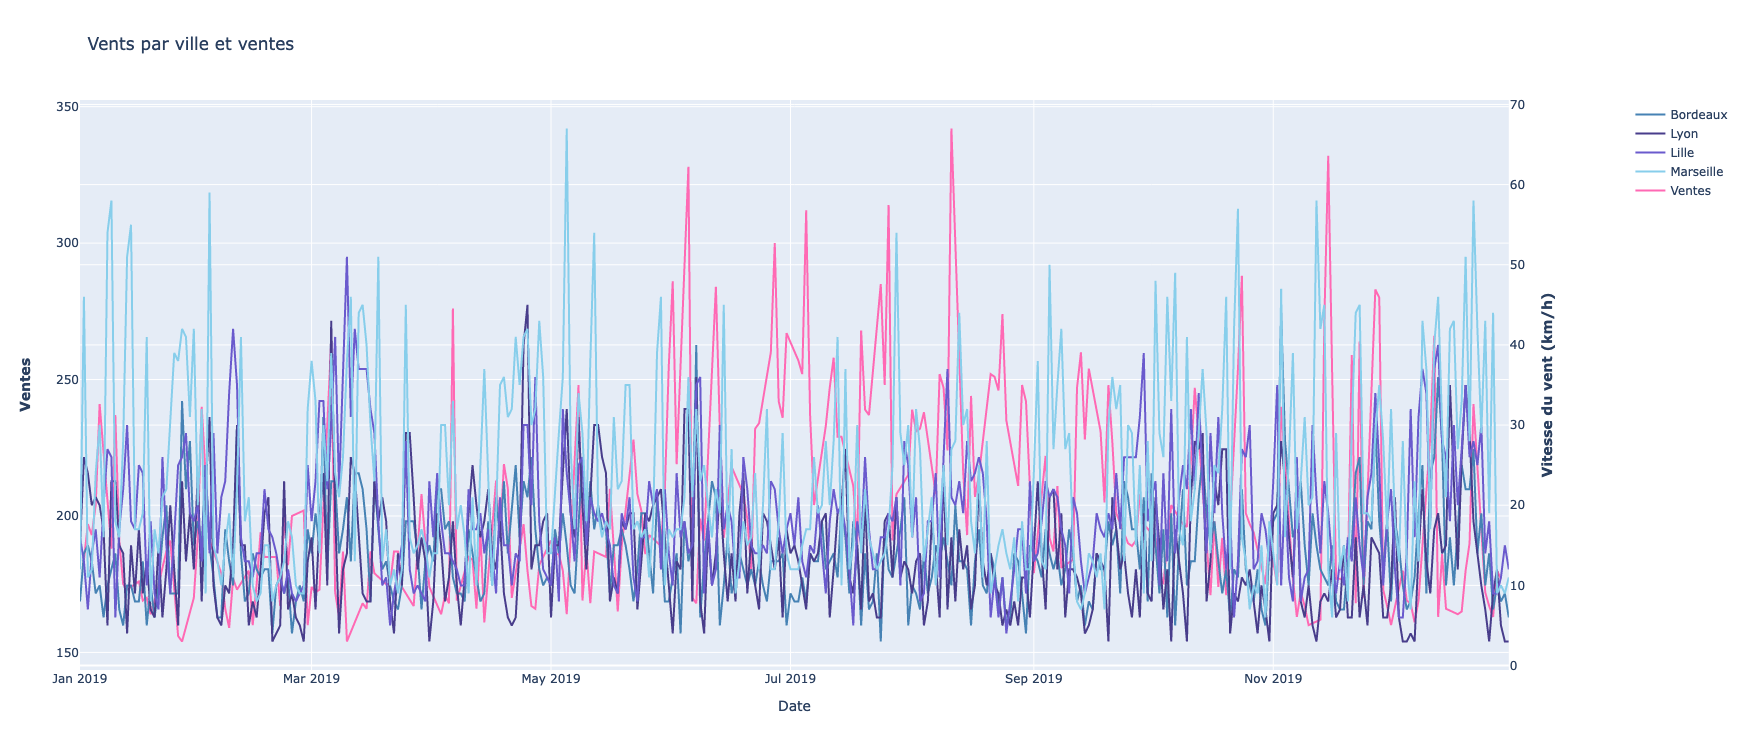

In [44]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

marseille_wind = marseille.windspeed_max_kmh
lyon_wind = lyon.windspeed_max_kmh
lille_wind = lille.windspeed_max_kmh
bordeaux_wind = bordeaux.windspeed_max_kmh


fig = go.Figure()
# Create figures with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]],)

fig.add_trace(
    go.Scatter(
        x=bordeaux.date,
        y=bordeaux_wind,
        line_color='steelblue',
        name='Bordeaux'
    ),
    secondary_y=True
)

fig.add_trace(
    go.Scatter(   
        x=lyon.date,
        y=lyon_wind,
        line_color='darkslateblue',
        name='Lyon'
    ),
    secondary_y=True   
)

fig.add_trace(
    go.Scatter(
        x=lille.date, y=lille_wind,
        line_color='slateblue',
        name='Lille'
    ),
    secondary_y=True
)


fig.add_trace(go.Scatter(
    x=marseille.date, 
    y=marseille_wind,
    line_color='skyblue',
    name='Marseille'),
    secondary_y=True,
)
fig.add_trace(go.Scatter(
    x=sales_by_date.date, y=sales_by_date.sales,
    line_color='hotpink',
    name='Ventes'),
    secondary_y=False,
)

# Add figure title and dimensions
fig.update_layout(
    autosize=False,
    width=1500,
    height=750,
    title_text="Vents par ville et ventes"
)


# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Ventes</b> ", secondary_y=False)
fig.update_yaxes(title_text="<b>Vitesse du vent (km/h)</b>", secondary_y=True)

#fig.update_traces(mode='lines')
fig.show()

In [45]:
opinion_sort_list = [
    'météo très défavorable',
    'météo défavorable', 
    'météo correcte',
    'météo favorable',
    'météo idéale'
]

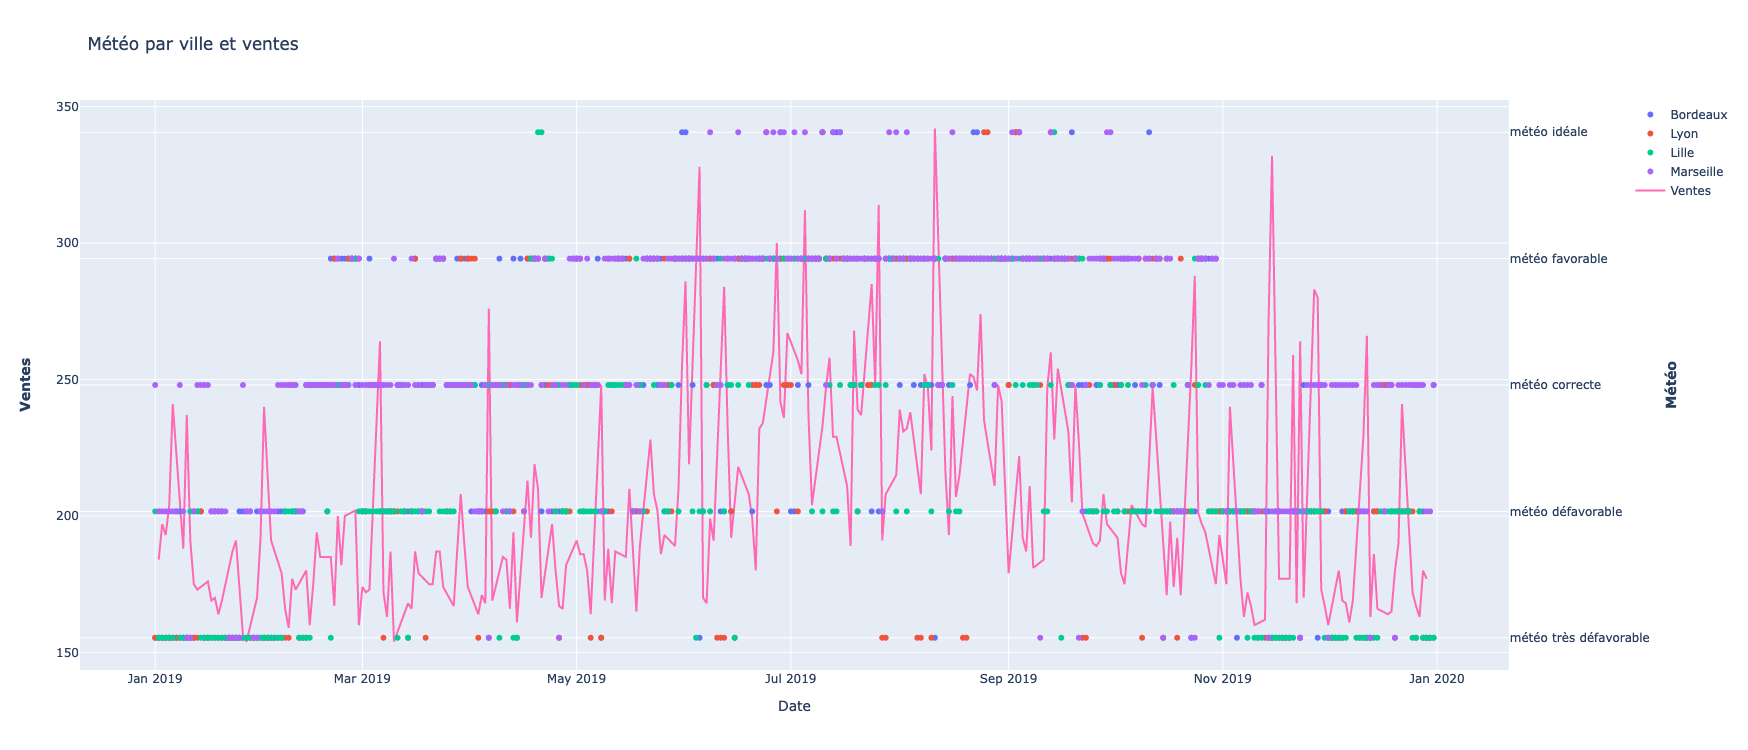

In [46]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

marseille_wind = marseille.opinion
lyon_wind = lyon.opinion
lille_wind = lille.opinion
bordeaux_wind = bordeaux.opinion


fig = go.Figure()
# Create figures with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]],)

fig.add_trace(
    go.Scatter(
        x=bordeaux.date,
        y=bordeaux_wind,
        #line_color='steelblue',
        mode='markers',
        name='Bordeaux',

    ),
    secondary_y=True
)


fig.add_trace(
    go.Scatter(   
        x=lyon.date,
        y=lyon_wind,
        mode='markers',
        #line_color='darkslateblue',
        name='Lyon'
    ),
    secondary_y=True   
)

fig.add_trace(
    go.Scatter(
        x=lille.date,
        y=lille_wind,        
        mode='markers',
        #line_color='slateblue',
        name='Lille'
    ),
    secondary_y=True
)


fig.add_trace(go.Scatter(
    x=marseille.date, 
    y=marseille_wind,
    #line_color='skyblue',
    mode='markers',
    name='Marseille',
    
    ),
    secondary_y=True,
)
fig.add_trace(go.Scatter(
    x=sales_by_date.date, y=sales_by_date.sales,
    line_color='hotpink',
    name='Ventes'),
    secondary_y=False,
)

# Add figure title and dimensions
fig.update_layout(
    autosize=False,
    width=1500,
    height=750,
    title_text="Météo par ville et ventes"
)




# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Ventes</b> ", secondary_y=False
                )

fig.update_yaxes(title_text="<b>Météo</b>", secondary_y=True, categoryorder='array', categoryarray=opinion_sort_list)

#fig.update_traces(mode='lines')
fig.show()

Il est assez difficile de trouver une corrélation en analysant le visuel. Il faudrait lisser les données si on veut rester sur une première analyse visuelle.<br>
Je vais partir sur une analyse statistique qui sera plus pertinente.

## Analyse statistique entre vent et ventes

**Méthode**<br>

Je vais d'abord mettre les données dont j'ai besoin dans un seul dataframe.

Avant de faire le test de dépendance, je vais vérifier quelques hypothèses (qui valide que les variables suivent une loi normale):

- l’indépendance entre les échantillons de chaque groupe : on considère ici que les échantillons sont bien indépendants.
- l’égalité des variances que l’on peut vérifier avec un test de *Bartlett*.
- la normalité des résidus avec un test de *Shapiro*.

In [47]:
df_merged=pd.DataFrame()

In [48]:
#for name, df in cities.items():
#    opinion_encoder(df)

In [49]:
for name, df in cities.items():
    temp_df_name = str(name)+"_df"
    temp_df_name=df.copy()
    temp_df_name=temp_df_name.loc[:,["windspeed_max_kmh","date"]].rename(columns={'windspeed_max_kmh' : 'windspeed_max_kmh_' + name})
    
    if df_merged.empty:
        df_merged = pd.merge(
            sales_by_date, temp_df_name,
            on=['date'],
            how='inner'
        )
    else :
        df_merged = pd.merge(
            df_merged, temp_df_name,
            on=['date'],
            how='inner'
        )          
          

In [50]:
df_merged

date  sales  windspeed_max_kmh_lyon  windspeed_max_kmh_bordeaux  \
0   2019-01-02    184                      26                          14   
1   2019-01-03    197                      24                          15   
2   2019-01-04    193                      20                          13   
3   2019-01-05    204                      21                           9   
4   2019-01-06    241                      20                          10   
..         ...    ...                     ...                         ...   
255 2019-12-25    172                       7                          10   
256 2019-12-26    167                       3                          14   
257 2019-12-27    163                       9                           7   
258 2019-12-28    180                      12                          10   
259 2019-12-29    177                       5                           8   

     windspeed_max_kmh_lille  windspeed_max_kmh_marseille  
0                         13                           46  
1                          7                           11  
2                         14                           12  
3                         17                           24  
4                         11                           30  
..                       ...                          ...  
255                       14                           43  
256                       18                           19  
257                        9                           44  
258                        9                            9  
259                       11                           10  

[260 rows x 6 columns]

### Egalité des variances

Le test de bartlett permet de tester si les variances sont significativement différentes ou non.

- H0 : Les variances de chaque groupe sont égales si p-value > 0.05
- Ha : Les variances de chaque groupe ne sont pas toutes égales si p-value < 0.05


In [51]:
for column in df_merged.iloc[:,2:6]:
    bartlett_pvalue = bartlett(df_merged["sales"], df_merged[column])[1]
    if bartlett_pvalue > alpha :
        print (
            colored(
                f"La p-value est supérieure à 0.05 ({bartlett_pvalue:.2e}), la variance entre les ventes et le vent à {str(column)[18:].capitalize()} est égale : la distribution est normale.",
                "blue",
                attrs=['bold']
            )
        )
    else:
        print (
            colored(
                f"La p-value est inférieure au seuil alpha 0.05 ({bartlett_pvalue:.2e}), la variance entre les ventes et le vent à {str(column)[18:].capitalize()} n'est pas égale : la distribution n'est pas normale.",
                "red"
            )
        )

La p-value est inférieure au seuil alpha 0.05 (4.37e-106), la variance entre les ventes et le vent à Lyon n'est pas égale : la distribution n'est pas normale.
La p-value est inférieure au seuil alpha 0.05 (2.45e-130), la variance entre les ventes et le vent à Bordeaux n'est pas égale : la distribution n'est pas normale.
La p-value est inférieure au seuil alpha 0.05 (4.98e-97), la variance entre les ventes et le vent à Lille n'est pas égale : la distribution n'est pas normale.
La p-value est inférieure au seuil alpha 0.05 (4.33e-59), la variance entre les ventes et le vent à Marseille n'est pas égale : la distribution n'est pas normale.


### Normalité des résidus

L’objectif est de s’assurer que les résidus suivent une loi normale afin de ne pas affirmer qu’il existe une différence de moyenne entre les groupes qui serait causée par le hasard.

On utilise le test de Shapiro-Wilk pour tester la normalité des résidus où :

H0 : Les résidus suivent une loi normale si p-value > 0.05<br>
Ha : Les résidus ne suivent pas une loi normale si p-value < 0.05

In [52]:
for column in df_merged.iloc[:,2:6]:
    model = ols('sales ~  df_merged[column]', data=df_merged).fit()
    shapiro_pvalue = shapiro(model.resid)[1]
    if shapiro_pvalue > alpha :
        print (
            colored(
                f"La p-value est supérieure au seuil alpha 0.05 (({shapiro_pvalue:.2e}), les résidus entre les ventes et le vent à {str(column)[18:].capitalize()} suivent une loi normale.",
                'blue',
                attrs=['bold']
            )
        )
           
    else :
        print( 
            colored(
                f"La p-value est inférieure à 0.05 ({shapiro_pvalue:.2e}), les résidus entre les ventes et le vent à {str(column)[18:].capitalize()} ne suivent pas une loi normale.",
                "red"
            )
        )


La p-value est inférieure à 0.05 (2.30e-12), les résidus entre les ventes et le vent à Lyon ne suivent pas une loi normale.
La p-value est inférieure à 0.05 (2.56e-12), les résidus entre les ventes et le vent à Bordeaux ne suivent pas une loi normale.
La p-value est inférieure à 0.05 (4.31e-12), les résidus entre les ventes et le vent à Lille ne suivent pas une loi normale.
La p-value est inférieure à 0.05 (2.58e-12), les résidus entre les ventes et le vent à Marseille ne suivent pas une loi normale.


**Conclusion**<br>
Notre échantillon étant petit et nos données ne suivant pas de loi normale, il faut utiliser des tests non paramétriques.

### Test de corrélation entre les données de vente et le vent

**Méthode**<br>
Je vais regarder si on peut considérer qu'une relation existe entre les ventes et le vent par ville.

**Hypothèses**<br>
- H0 : Variables indépendantes si p-value > alpha,<br>
- H1 : Variables dépendantes si p-value < alpha,<br>
- Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.

Je regarde d'abord la matrice de corrélation avec les coefficients.<br>


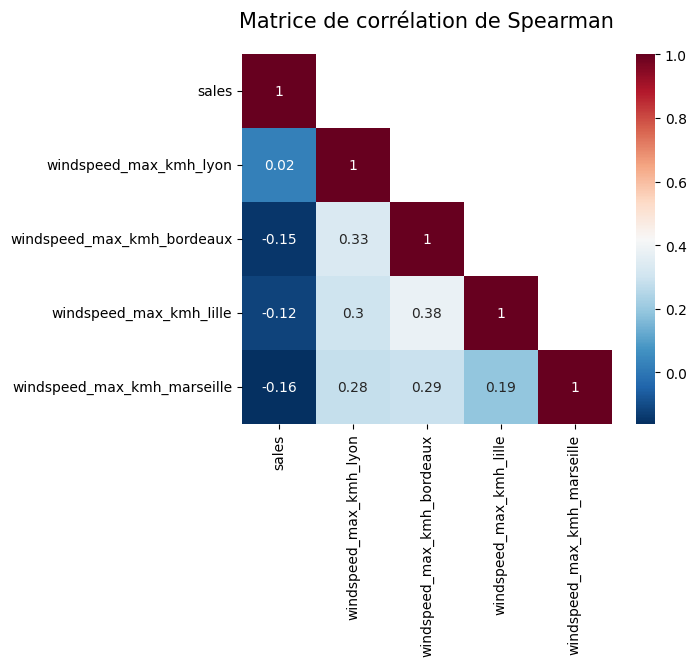

In [53]:
corr_matrix = df_merged.iloc[:,1:6].corr(method="spearman") # j'utilise Spearman car les données ne sont pas normalisées
mask = np.triu(np.ones_like(corr_matrix,dtype=bool),k=1)
sns.heatmap(
    corr_matrix,
    mask=mask,
    square=True,
    annot=True, 
    cbar=True, 
    cbar_kws={"shrink": 1},
    cmap = 'RdBu_r',
)
plt.title("Matrice de corrélation de Spearman", fontsize=15, loc='center', pad=20)
plt.show()


<u>Remarque</u><br>
Les corrélations négatives indiquent que les ventes baissent quand le vent augmente.

In [54]:
for column in df_merged.iloc[:,2:6]:
    coeff = spearmanr(df_merged.sales, df_merged[column])
    spearman_pvalue = coeff[1]
    if spearman_pvalue > alpha :
        print (colored (f"La p-value est supérieure à 0.05 ({spearman_pvalue}), il y n'y a pas de corrélation entre les ventes et le vent à {str(column)[18:].capitalize()}.", 'red'))
    else:
        print (colored (f"La p-value est inférieure au seuil alpha 0.05 ({spearman_pvalue}), il y a une dépendance entre les ventes et le vent à {str(column)[18:].capitalize()}.", 'blue',attrs=['bold']))
    

La p-value est supérieure à 0.05 (0.7468619227146998), il y n'y a pas de corrélation entre les ventes et le vent à Lyon.
La p-value est inférieure au seuil alpha 0.05 (0.018993421902834037), il y a une dépendance entre les ventes et le vent à Bordeaux.
La p-value est supérieure à 0.05 (0.05399761511183216), il y n'y a pas de corrélation entre les ventes et le vent à Lille.
La p-value est inférieure au seuil alpha 0.05 (0.00905891926392173), il y a une dépendance entre les ventes et le vent à Marseille.


## Conclusion
Si l'on se base uniquement sur le vent, c'est le vent à Marseille qui est le plus anti-corrélé aux ventes.

# 3. Explication de l'impact de la météo

Je vais commencer par supprimer les colonnes que je juge inutile dans les données météos.

In [55]:
marseille_df = marseille.copy()

Je supprime les colonnes "weather_code_x"

In [56]:
marseille_df.dtypes

date                      datetime64[ns]
max_temperature_c                  int64
min_temperature_c                  int64
windspeed_max_kmh                  int64
temperature_morning_c              int64
temperature_noon_c                 int64
temperature_evening_c              int64
precip_total_day_mm              float64
humidity_max_percent               int64
visibility_avg_km                float64
pressure_max_mb                    int64
cloudcover_avg_percent           float64
heatindex_max_c                    int64
dewpoint_max_c                     int64
windtemp_max_c                     int64
weather_code_morning               int64
weather_code_noon                  int64
weather_code_evening               int64
total_snow_mm                      int64
uv_index                           int64
sunhour                          float64
opinion                           object
dtype: object

In [57]:
marseille_df.drop(columns=["weather_code_morning", "weather_code_noon", "weather_code_evening"], inplace=True)

Les colonnes *max_temperature_c* et *heatindex_max_c* ont l'air identique. <br>
Je vérifie avant de supprimer l'une des colonnes.

In [58]:
j=0
for i in range(len(lyon)) :
    if marseille_df["max_temperature_c"][i] != marseille_df["heatindex_max_c"][i]:
        j=j+1
print(
    f"Il y a {j} lignes où les données ne sont pas égales."
)

Il y a 138 lignes où les données ne sont pas égales.


In [59]:
#lyon_df=lyon_df.merge(sales_by_date, how='inner', on = "date")
#lyon_df

In [60]:
temp_df = sales.groupby(["date", "item"],as_index=False).agg({"sales":"sum"})
temp_df

date item  sales
0   2019-01-02    A    113
1   2019-01-02    B     71
2   2019-01-03    A    143
3   2019-01-03    B     54
4   2019-01-04    A    145
..         ...  ...    ...
515 2019-12-27    B     87
516 2019-12-28    A    101
517 2019-12-28    B     79
518 2019-12-29    A    101
519 2019-12-29    B     76

[520 rows x 3 columns]

In [61]:
sales_marseille_by_product=marseille_df.merge(temp_df, how='inner', on = "date")
sales_marseille_by_product

date  max_temperature_c  min_temperature_c  windspeed_max_kmh  \
0   2019-01-02                 12                 10                 46   
1   2019-01-02                 12                 10                 46   
2   2019-01-03                 12                  7                 11   
3   2019-01-03                 12                  7                 11   
4   2019-01-04                 10                  7                 12   
..         ...                ...                ...                ...   
515 2019-12-27                 14                 13                 44   
516 2019-12-28                 13                 12                  9   
517 2019-12-28                 13                 12                  9   
518 2019-12-29                 12                 11                 10   
519 2019-12-29                 12                 11                 10   

     temperature_morning_c  temperature_noon_c  temperature_evening_c  \
0                        9                  12                     10   
1                        9                  12                     10   
2                        7                  10                     11   
3                        7                  10                     11   
4                        7                   9                      9   
..                     ...                 ...                    ...   
515                     12                  14                     14   
516                     11                  13                     13   
517                     11                  13                     13   
518                     11                  12                     12   
519                     11                  12                     12   

     precip_total_day_mm  humidity_max_percent  visibility_avg_km  \
0                    0.0                    53               10.0   
1                    0.0                    53               10.0   
2                    0.0                    54               10.0   
3                    0.0                    54               10.0   
4                    0.0                    49               10.0   
..                   ...                   ...                ...   
515                  0.0                    62               10.0   
516                  0.0                    55               10.0   
517                  0.0                    55               10.0   
518                  0.5                    72               10.0   
519                  0.5                    72               10.0   

     pressure_max_mb  cloudcover_avg_percent  heatindex_max_c  dewpoint_max_c  \
0               1027                   0.750               12               3   
1               1027                   0.750               12               3   
2               1029                   6.625               12               2   
3               1029                   6.625               12               2   
4               1031                  56.500               10               0   
..               ...                     ...              ...             ...   
515             1026                  17.500               14               7   
516             1032                  31.250               13               6   
517             1032                  31.250               13               6   
518             1033                  73.000               12               7   
519             1033                  73.000               12               7   

     windtemp_max_c  total_snow_mm  uv_index  sunhour            opinion item  \
0                 6              0         1      8.7  météo défavorable    A   
1                 6              0         1      8.7  météo défavorable    B   
2                 5              0         1      8.7  météo défavorable    A   
3                 5              0         1      8.7  météo défavorable    B   
4                 5      

Je déplace ma colonne qualitative opinion en début de tableau pour simplifier les filtres sur les données numériques.

In [62]:
col_to_move = sales_marseille_by_product.pop("opinion")
sales_marseille_by_product.insert(1,"opinion",col_to_move)
sales_marseille_by_product

date            opinion  max_temperature_c  min_temperature_c  \
0   2019-01-02  météo défavorable                 12                 10   
1   2019-01-02  météo défavorable                 12                 10   
2   2019-01-03  météo défavorable                 12                  7   
3   2019-01-03  météo défavorable                 12                  7   
4   2019-01-04  météo défavorable                 10                  7   
..         ...                ...                ...                ...   
515 2019-12-27     météo correcte                 14                 13   
516 2019-12-28     météo correcte                 13                 12   
517 2019-12-28     météo correcte                 13                 12   
518 2019-12-29  météo défavorable                 12                 11   
519 2019-12-29  météo défavorable                 12                 11   

     windspeed_max_kmh  temperature_morning_c  temperature_noon_c  \
0                   46                      9                  12   
1                   46                      9                  12   
2                   11                      7                  10   
3                   11                      7                  10   
4                   12                      7                   9   
..                 ...                    ...                 ...   
515                 44                     12                  14   
516                  9                     11                  13   
517                  9                     11                  13   
518                 10                     11                  12   
519                 10                     11                  12   

     temperature_evening_c  precip_total_day_mm  humidity_max_percent  \
0                       10                  0.0                    53   
1                       10                  0.0                    53   
2                       11                  0.0                    54   
3                       11                  0.0                    54   
4                        9                  0.0                    49   
..                     ...                  ...                   ...   
515                     14                  0.0                    62   
516                     13                  0.0                    55   
517                     13                  0.0                    55   
518                     12                  0.5                    72   
519                     12                  0.5                    72   

     visibility_avg_km  pressure_max_mb  cloudcover_avg_percent  \
0                 10.0             1027                   0.750   
1                 10.0             1027                   0.750   
2                 10.0             1029                   6.625   
3                 10.0             1029                   6.625   
4                 10.0             1031                  56.500   
..                 ...              ...                     ...   
515               10.0             1026                  17.500   
516               10.0             1032                  31.250   
517               10.0             1032                  31.250   
518               10.0             1033                  73.000   
519               10.0             1033                  73.000   

     heatindex_max_c  dewpoint_max_c  windtemp_max_c  total_snow_mm  uv_index  \
0                 12               3               6              0         1   
1                 12               3               6              0         1   
2                 12               2               5              0         1   
3                 12               2               5              0         1   
4                 10               0               5              0         1   
..               ...             ...             ...            ...       ...   
515               14           

## Impact de la météo globale

Je trie les opinions pour avoir le même ordre d'opinion dans mes boxplots

In [63]:
order_opinion_list=sales_marseille_by_product.opinion.unique()
order_opinion_list.sort(axis=0)
order_opinion_list

array(['météo correcte', 'météo défavorable', 'météo favorable',
       'météo idéale', 'météo très défavorable'], dtype=object)

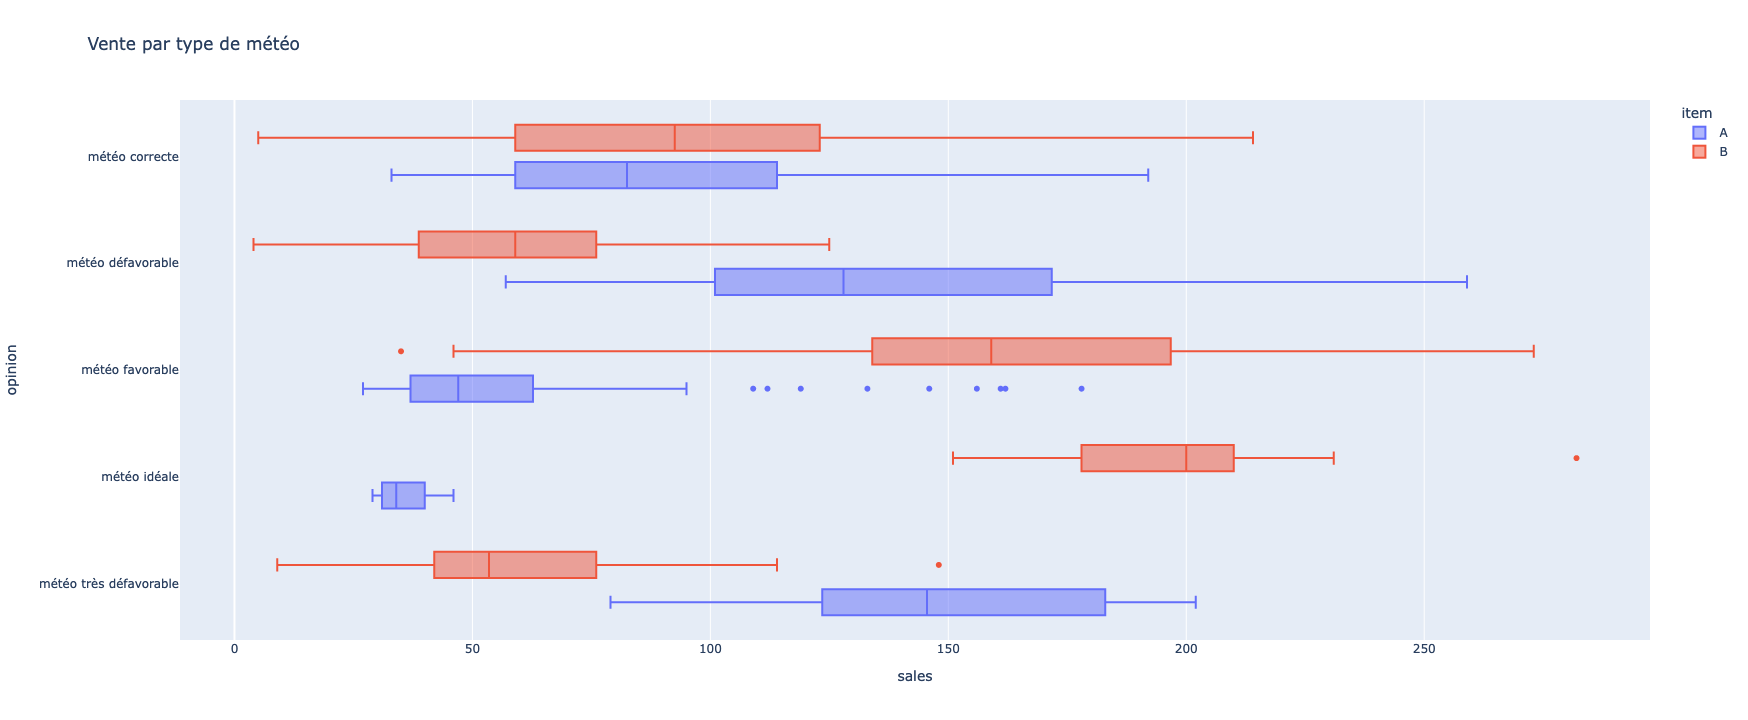

In [64]:
plot_sales_by_weather(sales_marseille_by_product, "item")

**Observation**<br>
En regardant par produit, le produit B, identifié comme se vendant bien en dehors de l'hiver, réalise les meilleures ventes lorsque la météo est qualifiée d'idéale avec une distribution peu étalée : on vend bien ces jours-ci!<br>
La météo favorable arrive ensuite et les pires ventes sont enregistrées les jours de météo très défavorable à défavorable.<br>

Pour le produit A, les meilleures ventes ont lieu lorsque la météo est très défavorable ou défavorable et on vend très peu lorsque la météo est idéale.

La saisonnalité est confirmée.

Ce graphique nous montre qu'il y a un lien entre la météo et le nombre de vente.<br>

Regardons la tendance sur les ventes totales.


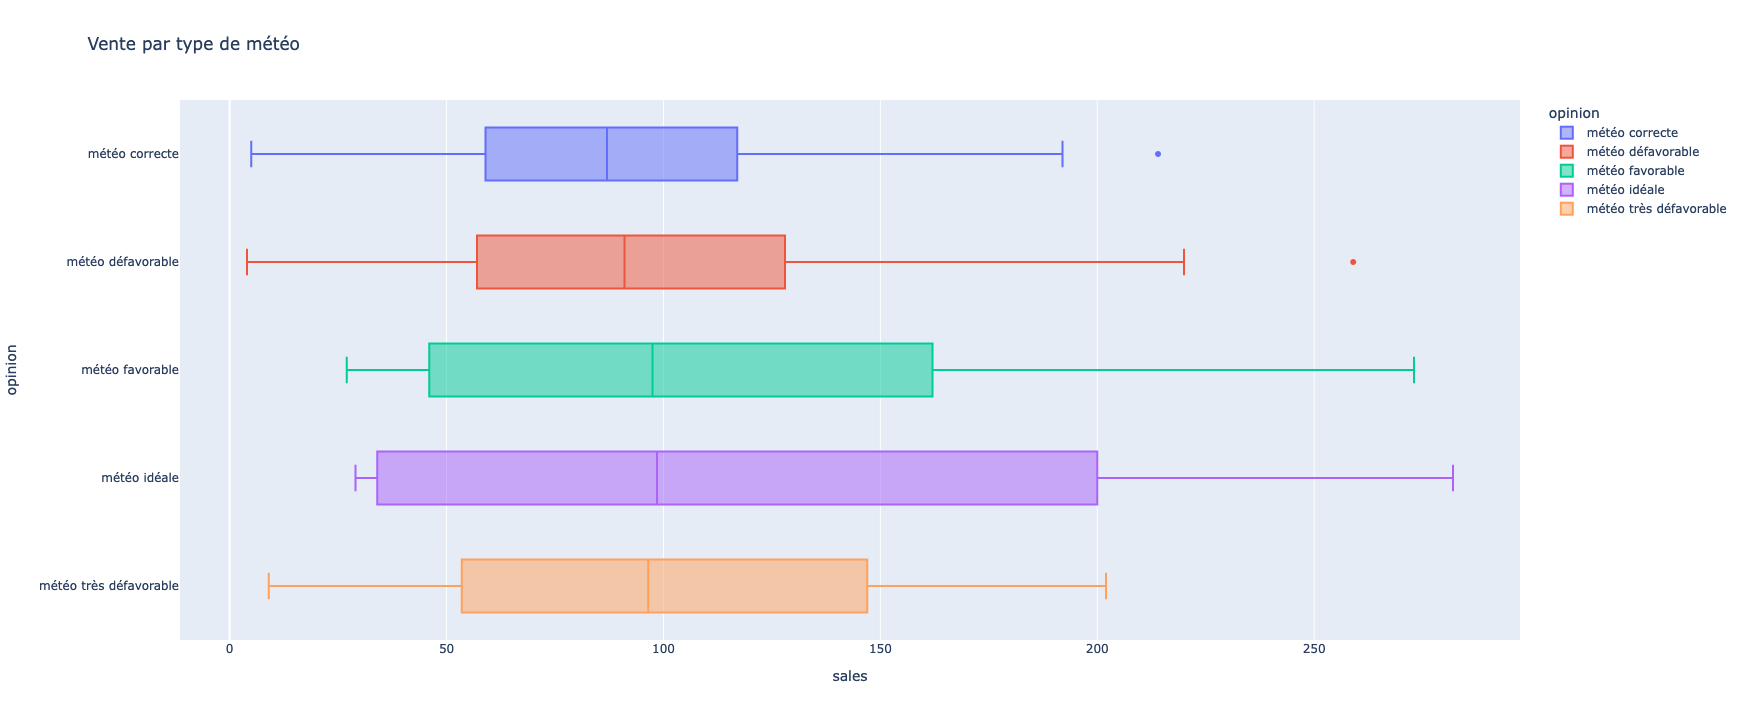

In [65]:
plot_sales_by_weather(sales_marseille_by_product, "opinion")

**Observation**<br>
La météo qualifiée d'idéale montre une distribution peu étalée plutôt vers le plus grand nombre de ventes quotidienne : on vend bien ces jours-ci!


La météo correcte a également une faible distribution mais plutôt basse. On est entre 2 saisons, donc les produits n'ont pas encore marqué leur territoire. La médiane des ventes est la plus faible.

La météo favorable arrive ensuite et les pires ventes sont enregistrées les jours de météo défavorable à très défavorable.<br>

On vend mieux lorsque la météo est très défavorable que défavorable : c'est l'impact des bonnes ventes du produit A sur la moins bonne saison certainement.

Ce graphique nous montre qu'il y a un lien entre la météo et le nombre de vente.<br>
Identifions les variables qui influent le plus sur les ventes.


Je vais séparer mes données en 2 dataframe, pour chacun des produits puisque le comportement est saisonnier.

In [66]:
sales_marseille_by_product_A=sales_marseille_by_product[sales_marseille_by_product.loc[:,"item"]=="A"]
sales_marseille_by_product_B=sales_marseille_by_product[sales_marseille_by_product.loc[:,"item"]=="B"]

In [67]:
sales_by_date_A=sales[sales.loc[:,"item"]=="A"]
sales_by_date_B=sales[sales.loc[:,"item"]=="B"]

In [68]:
sales_marseille_by_product_A=sales_marseille_by_product.merge(sales_by_date_A, how='inner', on = ["date","item","sales"])
sales_marseille_by_product_B=sales_marseille_by_product.merge(sales_by_date_B, how='inner', on = ["date","item","sales"])

Je déplace ma colonne qualitative opinion en début de tableau pour simplifier les filtres sur les données numériques.

In [69]:
dataframes = [sales_marseille_by_product_A,sales_marseille_by_product_B]
for df in dataframes:
    col_to_move = df.pop("opinion")
    df.insert(1,"opinion",col_to_move)


## Sélection de variables
On va trouver les variables les plus utiles. On peut travailler sur un seul dataframe pour cette partie puisqu'à part les ventes, les données sont identiques.

In [70]:
sales_marseille_by_product_B

date            opinion  max_temperature_c  min_temperature_c  \
0   2019-01-02  météo défavorable                 12                 10   
1   2019-01-03  météo défavorable                 12                  7   
2   2019-01-04  météo défavorable                 10                  7   
3   2019-01-05  météo défavorable                 10                  6   
4   2019-01-06  météo défavorable                 11                  8   
..         ...                ...                ...                ...   
255 2019-12-25     météo correcte                 15                 13   
256 2019-12-26     météo correcte                 13                 11   
257 2019-12-27     météo correcte                 14                 13   
258 2019-12-28     météo correcte                 13                 12   
259 2019-12-29  météo défavorable                 12                 11   

     windspeed_max_kmh  temperature_morning_c  temperature_noon_c  \
0                   46                      9                  12   
1                   11                      7                  10   
2                   12                      7                   9   
3                   24                      5                   8   
4                   30                      8                  10   
..                 ...                    ...                 ...   
255                 43                     13                  15   
256                 19                     11                  12   
257                 44                     12                  14   
258                  9                     11                  13   
259                 10                     11                  12   

     temperature_evening_c  precip_total_day_mm  humidity_max_percent  \
0                       10                  0.0                    53   
1                       11                  0.0                    54   
2                        9                  0.0                    49   
3                        9                  0.0                    57   
4                       10                  0.0                    61   
..                     ...                  ...                   ...   
255                     14                  0.0                    53   
256                     13                  0.0                    51   
257                     14                  0.0                    62   
258                     13                  0.0                    55   
259                     12                  0.5                    72   

     visibility_avg_km  pressure_max_mb  cloudcover_avg_percent  \
0                 10.0             1027                   0.750   
1                 10.0             1029                   6.625   
2                 10.0             1031                  56.500   
3                 10.0             1029                  29.125   
4                 10.0             1026                  11.625   
..                 ...              ...                     ...   
255               10.0             1022                   3.625   
256               10.0             1026                  14.500   
257               10.0             1026                  17.500   
258               10.0             1032                  31.250   
259               10.0             1033                  73.000   

     heatindex_max_c  dewpoint_max_c  windtemp_max_c  total_snow_mm  uv_index  \
0                 12               3               6              0         1   
1                 12               2               5              0         1   
2                 10               0               5              0         1   
3                 10               1               2              0         1   
4                 11               2               4              0         1   
..               ...             ...             ...            ...       ...   
255               15           

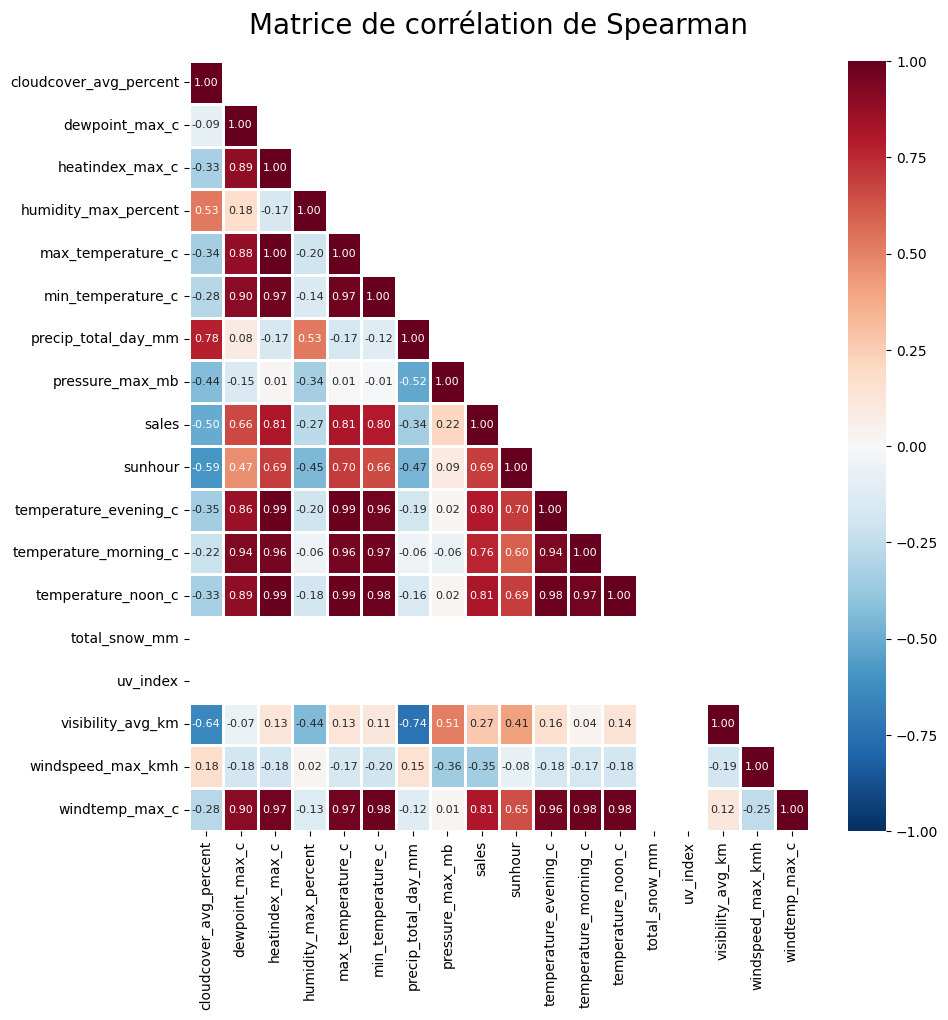

In [71]:
sales_marseille_by_product_B_corr = (sales_marseille_by_product_B[sales_marseille_by_product_B.columns.difference(["date","opinion","item"])].corr(method = "spearman"))

plot_corr_matrix(sales_marseille_by_product_B_corr)

Je représente mes variables explcatives par rapport au ventes par produit

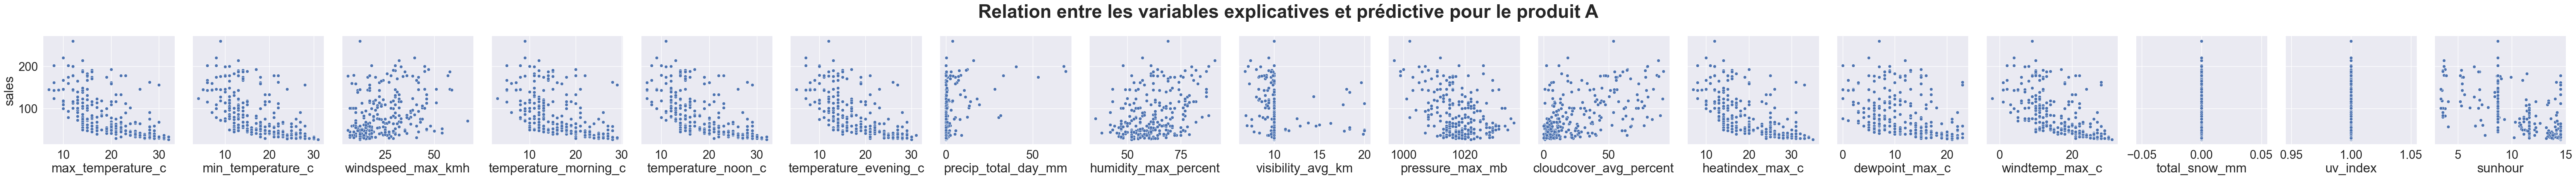

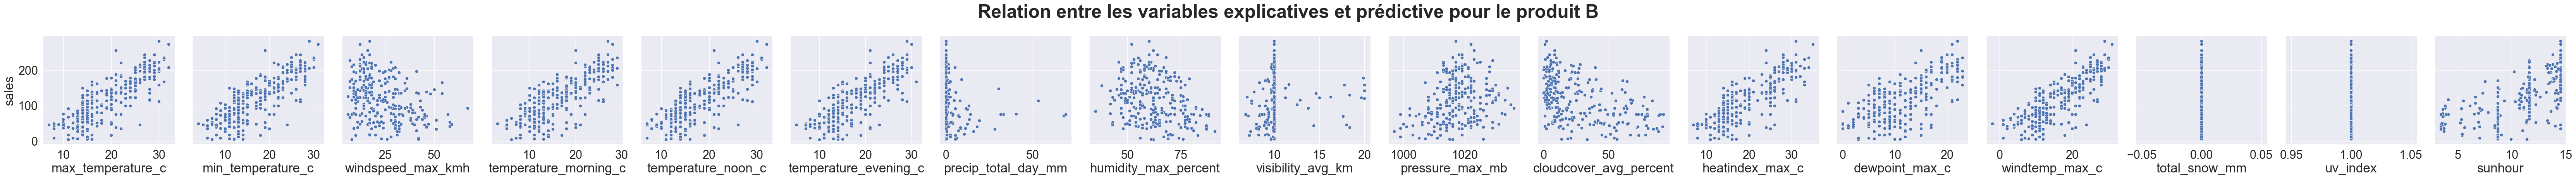

In [72]:
dataframes =[sales_marseille_by_product_A, sales_marseille_by_product_B]
sales_marseille_by_product_A.name = "A"
sales_marseille_by_product_B.name = "B"

for df in dataframes:   
    if df.name == "A":
        product = "A"
    else:
        product="B"
    plot_var_with_sales(df, product)

Je sépare mon jeu de données en 2 : d'un côté les variables explicatives, de l'autre les ventes.

In [73]:
X=sales_marseille_by_product_B.drop(["date", "opinion", "sales", "item"], axis=1)
X

max_temperature_c  min_temperature_c  windspeed_max_kmh  \
0                   12                 10                 46   
1                   12                  7                 11   
2                   10                  7                 12   
3                   10                  6                 24   
4                   11                  8                 30   
..                 ...                ...                ...   
255                 15                 13                 43   
256                 13                 11                 19   
257                 14                 13                 44   
258                 13                 12                  9   
259                 12                 11                 10   

     temperature_morning_c  temperature_noon_c  temperature_evening_c  \
0                        9                  12                     10   
1                        7                  10                     11   
2                        7                   9                      9   
3                        5                   8                      9   
4                        8                  10                     10   
..                     ...                 ...                    ...   
255                     13                  15                     14   
256                     11                  12                     13   
257                     12                  14                     14   
258                     11                  13                     13   
259                     11                  12                     12   

     precip_total_day_mm  humidity_max_percent  visibility_avg_km  \
0                    0.0                    53               10.0   
1                    0.0                    54               10.0   
2                    0.0                    49               10.0   
3                    0.0                    57               10.0   
4                    0.0                    61               10.0   
..                   ...                   ...                ...   
255                  0.0                    53               10.0   
256                  0.0                    51               10.0   
257                  0.0                    62               10.0   
258                  0.0                    55               10.0   
259                  0.5                    72               10.0   

     pressure_max_mb  cloudcover_avg_percent  heatindex_max_c  dewpoint_max_c  \
0               1027                   0.750               12               3   
1               1029                   6.625               12               2   
2               1031                  56.500               10               0   
3               1029                  29.125               10               1   
4               1026                  11.625               11               2   
..               ...                     ...              ...             ...   
255             1022                   3.625               15               8   
256             1026                  14.500               13               5   
257             1026                  17.500               14               7   
258             1032                  31.250               13               6   
259             1033                  73.000               12               7   

     windtemp_max_c  total_snow_mm  uv_index  sunhour  
0                 6              0         1      8.7  
1                 5              0         1      8.7  
2                 5              0         1      3.4  
3                 2              0         1      8.7  
4                 4              0         1      8.7  
..              ...            ...       ...      ...  
255              10              0         1      8.7  
256              11              0         1      8.7  
257              10              0         1      8.7

In [74]:
y_b=sales_marseille_by_product_B["sales"]
y_b

0      71
1      54
2      48
3      37
4      39
       ..
255    96
256    85
257    87
258    79
259    76
Name: sales, Length: 260, dtype: int64

## Importance des dimensions : sélecteur variance

VarianceThreshold : sélectionne les variables selon leur degré de variation : élimine les variables dont la variance est inférieure au seuil défini.


On affiche la variance de toutes nos données de X

In [75]:
pd.DataFrame(X.var(axis=0).sort_values(ascending=False))

0
cloudcover_avg_percent  643.960748
windspeed_max_kmh       156.035328
humidity_max_percent    119.515815
precip_total_day_mm      72.918309
windtemp_max_c           57.406163
pressure_max_mb          49.632477
heatindex_max_c          45.825884
min_temperature_c        41.045604
temperature_noon_c       39.880071
temperature_morning_c    38.990362
max_temperature_c        37.579730
temperature_evening_c    37.121755
dewpoint_max_c           36.393763
sunhour                  10.871003
visibility_avg_km         4.361714
total_snow_mm             0.000000
uv_index                  0.000000

In [76]:
med_var =X.var(axis=0).median()
mean_var = X.var(axis=0).mean()
print ("Variabilité médiane : " ,med_var)
print("Variabilité moyenne : ",mean_var)

Variabilité médiane :  39.88007128007131
Variabilité moyenne :  81.8552191807596


Je vais conserver les variables dont la variance est supérieure à la médiane.

In [77]:
selector = VarianceThreshold(threshold=med_var)
selector.fit_transform(X)
features_selected_var = np.array(X.columns)[selector.get_support()] #affichage des variables conservées
features_selected_var

array(['min_temperature_c', 'windspeed_max_kmh', 'precip_total_day_mm',
       'humidity_max_percent', 'pressure_max_mb',
       'cloudcover_avg_percent', 'heatindex_max_c', 'windtemp_max_c'],
      dtype=object)

## Corrélation : sélecteur statistique

SelectKBest sélectionne les k variables x dont le score de test de dépendance avec y est le plus élevé.<br>
Le premier tableau correspond au f-score, le second à la p-value.

In [78]:
fscore, pvalue = f_regression(X, y_b)

Je souhaite conserver la moitié de mes variables

In [79]:
nb_var=int(X.shape[1] / 2)
selector = SelectKBest(f_regression, k=nb_var) 
selector.fit_transform(X, y_b)
features_selected_kbest = np.array(X.columns)[selector.get_support()]
features_selected_kbest

array(['max_temperature_c', 'min_temperature_c', 'temperature_morning_c',
       'temperature_noon_c', 'temperature_evening_c', 'heatindex_max_c',
       'dewpoint_max_c', 'windtemp_max_c'], dtype=object)

## Conclusion

**Les variables ayant le plus de variances vont être intéressantes pour entraîner un modèle de prédiction. Dans les 8 variables ayant les variances les plus importantes, on retrouve les 2 liées au vent, dont la vitesse en seconde position.**

**Concernant la corrélation des variables au volume des vente, la vitesse du vent n'est pas conservée contrairement à la température ressentie avec le vent.**

Pour plus de visibilité, je vais créer un dataframe en classant les variables sélectionnées de la plus importante (meilleur fscore) à la moins importante.

In [80]:
best_var=pd.DataFrame([X.columns, fscore])
best_var

0                  1                  2   \
0  max_temperature_c  min_temperature_c  windspeed_max_kmh   
1         499.483501         462.820366           35.03877   

                      3                   4                      5   \
0  temperature_morning_c  temperature_noon_c  temperature_evening_c   
1             399.401991          508.555042             475.802003   

                    6                     7                  8   \
0  precip_total_day_mm  humidity_max_percent  visibility_avg_km   
1            10.293247             22.401077           1.857912   

                9                       10               11              12  \
0  pressure_max_mb  cloudcover_avg_percent  heatindex_max_c  dewpoint_max_c   
1        14.175836               79.986212       482.658891      228.028928   

               13             14        15          16  
0  windtemp_max_c  total_snow_mm  uv_index     sunhour  
1      471.390449            0.0       0.0  190.391349

Je transpose mon tableau

In [82]:
best_var = best_var.transpose()
best_var.rename(columns={0:"variable", 1:"fscore"}, inplace=True)
best_var

variable      fscore
0        max_temperature_c  499.483501
1        min_temperature_c  462.820366
2        windspeed_max_kmh    35.03877
3    temperature_morning_c  399.401991
4       temperature_noon_c  508.555042
5    temperature_evening_c  475.802003
6      precip_total_day_mm   10.293247
7     humidity_max_percent   22.401077
8        visibility_avg_km    1.857912
9          pressure_max_mb   14.175836
10  cloudcover_avg_percent   79.986212
11         heatindex_max_c  482.658891
12          dewpoint_max_c  228.028928
13          windtemp_max_c  471.390449
14           total_snow_mm         0.0
15                uv_index         0.0
16                 sunhour  190.391349

Pour pouvoir trier sur une donnée numérique, je m'assure du type de mes données.

In [83]:
best_var.dtypes

variable    object
fscore      object
dtype: object

Je convertis ma colonne fscore en float et je trie le dataframe par fscore.

In [84]:
best_var["fscore"]=best_var["fscore"].astype(float)
best_var.sort_values(by='fscore', ascending=False, inplace=True)


In [85]:
best_var

variable      fscore
4       temperature_noon_c  508.555042
0        max_temperature_c  499.483501
11         heatindex_max_c  482.658891
5    temperature_evening_c  475.802003
13          windtemp_max_c  471.390449
1        min_temperature_c  462.820366
3    temperature_morning_c  399.401991
12          dewpoint_max_c  228.028928
16                 sunhour  190.391349
10  cloudcover_avg_percent   79.986212
2        windspeed_max_kmh   35.038770
7     humidity_max_percent   22.401077
9          pressure_max_mb   14.175836
6      precip_total_day_mm   10.293247
8        visibility_avg_km    1.857912
14           total_snow_mm    0.000000
15                uv_index    0.000000

Je n'affiche que les variables sélectionnées.

In [86]:
data_to_keep = best_var.variable.isin(features_selected_kbest)
data_to_keep_corr=best_var.loc[data_to_keep,:]
data_to_keep_corr

variable      fscore
4      temperature_noon_c  508.555042
0       max_temperature_c  499.483501
11        heatindex_max_c  482.658891
5   temperature_evening_c  475.802003
13         windtemp_max_c  471.390449
1       min_temperature_c  462.820366
3   temperature_morning_c  399.401991
12         dewpoint_max_c  228.028928

**Les variables liées à la tempéarture influent le plus sur les ventes, dont la température ressentie liée au vent.<br>
La vitesse du vent n'est pas beaucoup corrélée aux ventes.**

# 4. Prévisions de ventes 

## Séparation de mon jeu de données

J'ai une variable à prédire pour le produit A

In [88]:
y_a=sales_marseille_by_product_A["sales"]
y_a

0      113
1      143
2      145
3      167
4      202
      ... 
255     76
256     82
257     76
258    101
259    101
Name: sales, Length: 260, dtype: int64

Et une pour le produit B

In [97]:
y_b

0      71
1      54
2      48
3      37
4      39
       ..
255    96
256    85
257    87
258    79
259    76
Name: sales, Length: 260, dtype: int64

## Sélection de colonnes

In [98]:
forecast.columns = forecast.columns.str.lower()
forecast

date  max_temperature_c  min_temperature_c  windspeed_max_kmh  \
0  2021-06-21                 20                 14                 23   
1  2021-06-22                 25                 17                 10   
2  2021-06-23                 25                 18                 19   
3  2021-06-24                 32                 23                 12   
4  2021-06-25                 28                 20                 13   
5  2021-06-26                 20                 16                 19   
6  2021-06-27                 21                 15                 31   

   precip_total_day_mm  humidity_max_percent  visibility_avg_km  \
0                  2.0                    92                7.0   
1                  0.0                    73                9.0   
2                  0.0                    79               10.0   
3                  0.0                    76               10.0   
4                  1.0                    82               10.0   
5                  0.0                    88                9.0   
6                  1.0                    89                9.0   

   pressure_max_mb  cloudcover_avg_percent  
0             1025                    61.0  
1             1027                    26.0  
2             1024                    19.0  
3             1018                     2.0  
4             1015                    36.0  
5             1013                    89.0  
6             1015                    76.0

Je regarde les variables communes entre celles sélectionnées par la variance et celles du fichier de prévisions.

In [99]:
difference_features_var = set(forecast.iloc[:,1:].columns).difference(set(features_selected_var))
print (f'''Les variables '{', '.join(difference_features_var)}' issues du fichier 'forecast' ne sont pas présentes dans la sélection de variable ayant le plus de variance'.''')

difference_features_corr = set(forecast.iloc[:,1:].columns).difference(set(data_to_keep_corr.variable))
print (f'''Les variables '{', '.join(difference_features_corr)}' issues du fichier 'forecast' ne sont pas présentes dans la sélection de variable les plus corrélées.''')

Les variables 'visibility_avg_km, max_temperature_c' issues du fichier 'forecast' ne sont pas présentes dans la sélection de variable ayant le plus de variance'.
Les variables 'windspeed_max_kmh, cloudcover_avg_percent, humidity_max_percent, visibility_avg_km, pressure_max_mb, precip_total_day_mm' issues du fichier 'forecast' ne sont pas présentes dans la sélection de variable les plus corrélées.


Afin de faire mes prévisions, je vais entraîner le fichier météo de ma ville sur les mêmes variables que celles disponibles dans le fichier de prévisions,<br>
mais en supprimant la variable  'visibility_avg_km' dont la variance et la corrélation ne sont pas importantes.

In [153]:
col_to_keep = forecast.columns.difference(['date','visibility_avg_km'])
col_to_keep

Index(['cloudcover_avg_percent', 'humidity_max_percent', 'max_temperature_c',
       'min_temperature_c', 'precip_total_day_mm', 'pressure_max_mb',
       'windspeed_max_kmh'],
      dtype='object')

In [154]:
X.drop(columns=X.columns.difference(col_to_keep), inplace=True)
X

max_temperature_c  min_temperature_c  windspeed_max_kmh  \
0                 20                 14                 23   
1                 25                 17                 10   
2                 25                 18                 19   
3                 32                 23                 12   
4                 28                 20                 13   
5                 20                 16                 19   
6                 21                 15                 31   

   precip_total_day_mm  humidity_max_percent  pressure_max_mb  \
0                  2.0                    92             1025   
1                  0.0                    73             1027   
2                  0.0                    79             1024   
3                  0.0                    76             1018   
4                  1.0                    82             1015   
5                  0.0                    88             1013   
6                  1.0                    89             1015   

   cloudcover_avg_percent  
0                    61.0  
1                    26.0  
2                    19.0  
3                     2.0  
4                    36.0  
5                    89.0  
6                    76.0

## Produit A

### Echantillonnage

Je sépare mon jeu de données : entraînement et test

In [ ]:
#X_train, X_test, y_train, ya_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

In [103]:
X_train, X_test, y_train, ya_test = data_sampling(X, y_a)

Le jeu de données d'entraînement contient 208 lignes.
Le jeu de test en contient 52.


### Normalisation des données

Je n'aurais pas besoin de répéter cette étape pour le produit B.

In [106]:
std_scaler = StandardScaler()

J'entraîne et je transforme sur mon jeu d'entraînement

In [107]:
X_train_scl = std_scaler.fit_transform(X_train)
X_train_scl=pd.DataFrame(X_train_scl, columns=X_train.columns, index=X_train.index)
X_train_scl.head()

max_temperature_c  min_temperature_c  windspeed_max_kmh  \
60           -0.710020          -0.630965          -0.823554   
247          -0.871777          -0.630965           1.726016   
16           -2.004075          -1.872011           0.451231   
55           -0.871777          -0.786095          -0.584532   
125           1.878091           2.006259          -0.982902   

     precip_total_day_mm  humidity_max_percent  pressure_max_mb  \
60             -0.314048             -1.804639         1.336721   
247             1.833919              1.332365        -2.259790   
16             -0.314048             -0.997981        -1.568153   
55             -0.314048             -1.177238         1.613376   
125            -0.314048             -0.818723         0.783412   

     cloudcover_avg_percent  
60                -0.853105  
247                2.517281  
16                 0.007625  
55                -0.630669  
125               -0.988500

Je transforme mon jeu de test

In [108]:
X_test_scl = std_scaler.transform(X_test)
X_test_scl=pd.DataFrame(X_test_scl, columns=X_test.columns, index=X_test.index)
X_test_scl.head()

max_temperature_c  min_temperature_c  windspeed_max_kmh  \
30           -0.871777          -1.096357          -0.265836   
181           1.231064           1.230605          -1.301599   
223          -1.033534          -1.096357           0.530905   
185           0.907550           1.075474          -0.823554   
211          -0.062992           0.144689          -0.664206   

     precip_total_day_mm  humidity_max_percent  pressure_max_mb  \
30             -0.314048             -0.549837         2.443340   
181            -0.314048             -0.280951         1.475048   
223            -0.254383              0.525707        -1.014844   
185            -0.314048              0.884221        -0.323207   
211             6.022455              0.884221        -0.184880   

     cloudcover_avg_percent  
30                -0.944980  
181               -0.940145  
223               -0.195468  
185               -0.577478  
211                1.119804

### Choix de l'estimateur
Je recherche le meilleur estimateur à partir d'une préselection faite en se basant sur l'aide de scikit-learn : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html<br>
Je choisis :
 - une régression linéaire classique
 - une régression Ridge ou SVR car je veux tester avec toutes mes variables
 - des modèles d'ensembles
 - Régression Lasso et Elasticnet


Liste de mes estimateurs

In [110]:
LinearReg = LinearRegression()
RidgeReg =  Ridge(random_state=42)
RandomForestReg = RandomForestRegressor(random_state=42) 
SVR = svm.SVR(kernel="linear")
GradientTree = GradientBoostingRegressor()
LassoReg =  Lasso(random_state=42)
ElasticNetReg =ElasticNet(random_state=42)

Je créé un dictionnaire de mes modèles pour pouvoir itérer dessus et choisir le meilleur.

In [111]:
dict_of_models = {
    'LinearRegression' : LinearReg,
    'RidgeReg' : RidgeReg,
    'RandomForestRegressor':RandomForestReg,
    'SVR':SVR,
    'GradientTree':GradientTree,
    'LassoReg':LassoReg ,
    'ElasticNetReg' :ElasticNetReg
}

In [112]:
select_best_model(dict_of_models ,X_train_scl, X_test_scl, y_train, ya_test)

LinearRegression : r2_score =  0.715
RidgeReg : r2_score =  0.7135
RandomForestRegressor : r2_score =  0.6827
SVR : r2_score =  0.6719
GradientTree : r2_score =  0.6988
LassoReg : r2_score =  0.7047
ElasticNetReg : r2_score =  0.6541

Le meilleur modèle est LinearRegression.


In [113]:
model_lin = LinearRegression()
model_lin.fit(X_train_scl, y_train)

LinearRegression()

### Evaluation du modèle

Je déploie mon modèle sur mon échantillon de test

In [114]:
y_pred_a = np.round(model_lin.predict(X_test_scl),2)

In [115]:
coef = pd.DataFrame(model_lin.coef_.reshape(-1,1) ,index = X_train.columns, columns=['Coef']) # pentes
coef.loc['Constante'] = model_lin.intercept_ # ordonnées à l'origine
coef

Coef
max_temperature_c      -24.954419
min_temperature_c       -0.332281
windspeed_max_kmh        5.648792
precip_total_day_mm      4.096867
humidity_max_percent     1.240196
pressure_max_mb        -11.331588
cloudcover_avg_percent   7.549207
Constante               85.144231

In [144]:
display_scores(ya_test,y_pred_a)

Racine carrée de l'erreur quadratique moyenne :  8.38871036320198
Moyenne absolue des erreurs : 21.179423076923076
Log de la médiane absolue des erreurs : 17.25
Le coefficient de détermination (Score R² de précision) vaut: 0.71.


### Visualisation des prédictions
Affichage de la distribution de chaque variable explicative par rapport à la variable prédictive

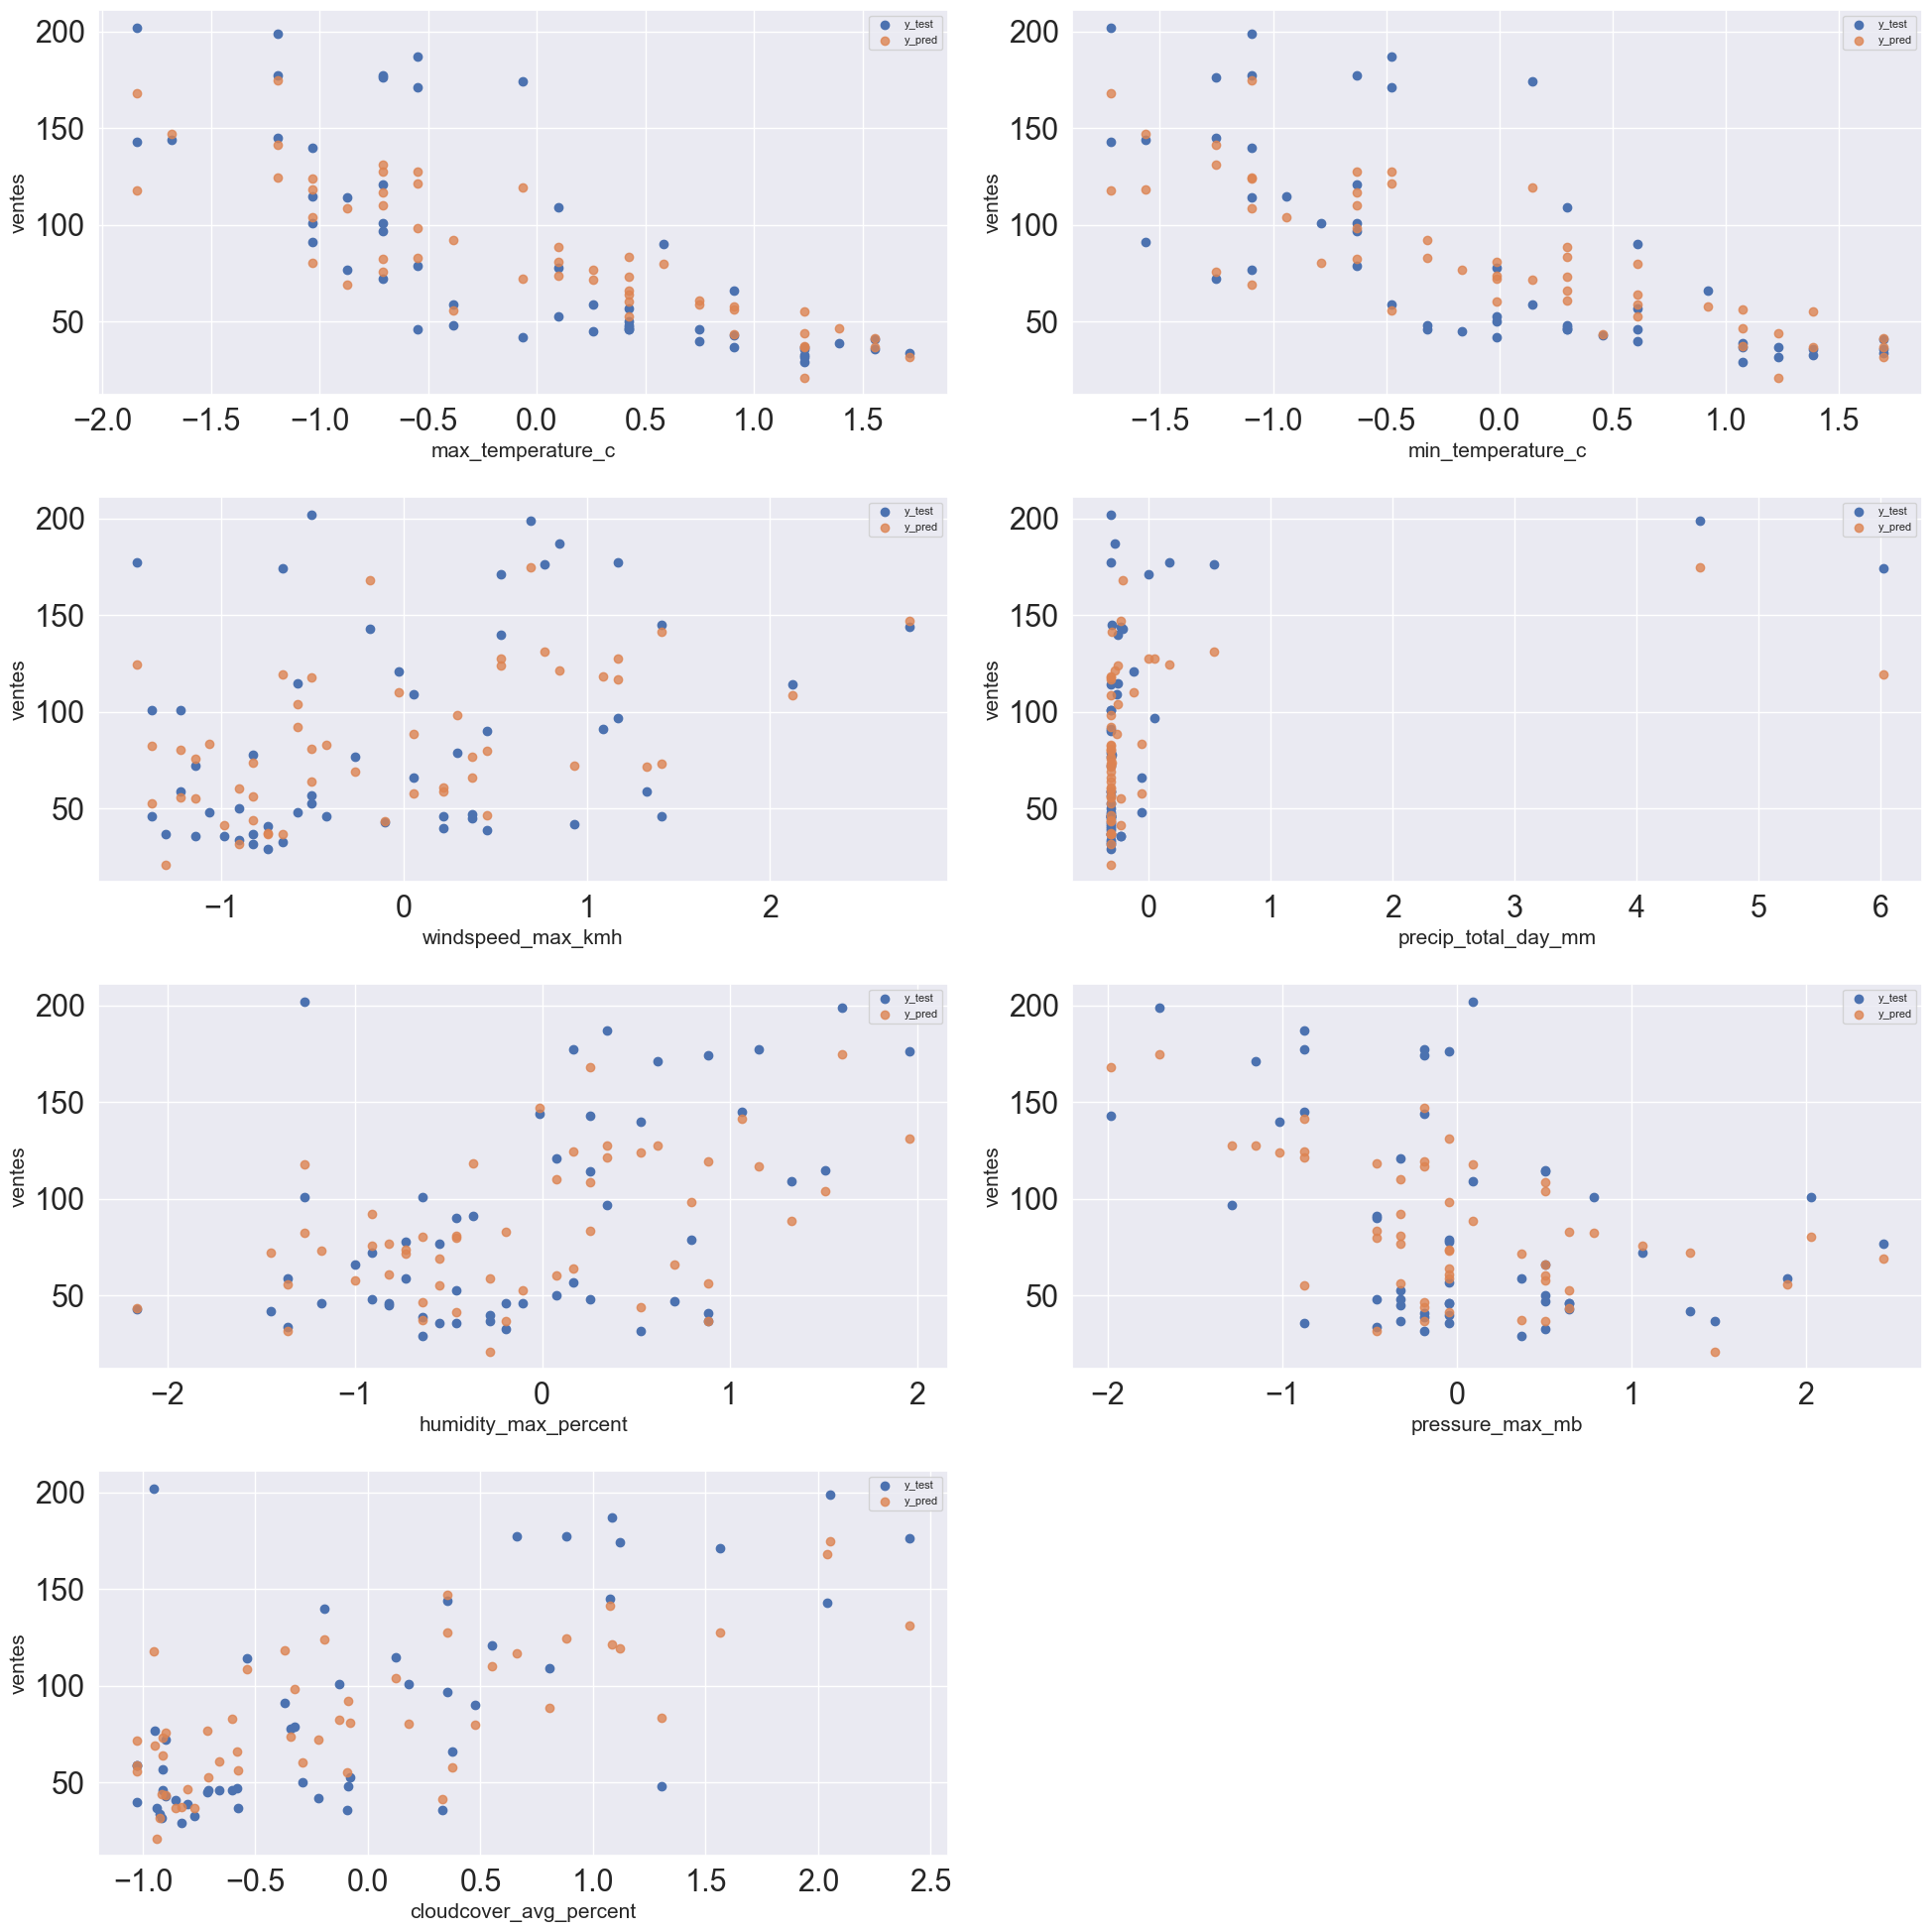

In [125]:
fig = plt.figure(figsize=(20, 20))

for i in range(X_train_scl.shape[1]):
    ax = fig.add_subplot(4,2, (i+1))
    plt.scatter(X_test_scl.iloc[:,i],ya_test,label="y_test")
    plt.scatter(X_test_scl.iloc[:,i],y_pred_a,label="y_pred", alpha=0.8)
    plt.xlabel(X_test_scl.columns[i], size = 15)
    plt.ylabel("ventes", size=15)
    plt.tight_layout()
    plt.legend(prop={'size': 8})

## Produit B

In [126]:
X_train, X_test, y_train, yb_test = data_sampling(X, y_b)

Le jeu de données d'entraînement contient 208 lignes.
Le jeu de test en contient 52.


### Choix de l'estimateur

In [127]:
select_best_model(dict_of_models ,X_train_scl, X_test_scl, y_train, yb_test)

LinearRegression : r2_score =  0.7794
RidgeReg : r2_score =  0.7796
RandomForestRegressor : r2_score =  0.7948
SVR : r2_score =  0.7944
GradientTree : r2_score =  0.7996
LassoReg : r2_score =  0.7866
ElasticNetReg : r2_score =  0.7648

Le meilleur modèle est GradientTree.


### Paramètres de l'estimateur
Maintenant que j'ai mon estimateur, je vais travailler sur le paramètrage<br>
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [131]:
parameters_gb = {
    'learning_rate' : np.arange(start = 0.2, stop = 0.41, step = 0.05), 
    'n_estimators':np.arange(start = 20, stop = 61, step = 10), 
    'min_samples_leaf':np.arange(start = 2, stop = 11, step = 2), 
    'max_depth':np.arange(start = 4, stop = 7, step = 1), 
    'max_features' : ['sqrt', 'log2'], 
    'min_samples_split' : np.arange(start = 2, stop = 5, step = 1), 
    #'subsample' : np.arange(start = 0.6, stop = 0.9, step = 0.05), 
    'random_state':[42]
}
number_of_combination(parameters_gb, number_of_split=5, longtime='y')

Il y a 2250 combinaisons à tester sur 5 cross-validation, soit 11250 possibilités.
Tu peux faire une petite pause, l'apprentissage devrait se terminer le 07/11/2022 vers 23:36:47.


In [132]:
model_gb = GridSearchCV(GradientBoostingRegressor(), parameters_gb, scoring = 'r2', cv=5, verbose = 1, n_jobs=-1)
model_gb.fit(X_train_scl, y_train)
end_training = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print (f"Fin de l'apprentissage : {end_training}")

Fitting 5 folds for each of 2250 candidates, totalling 11250 fits
Fin de l'apprentissage : 07/11/2022 23:28:06


In [133]:
print(f"""Le score moyen du meilleur modèle vaut {round(model_gb.best_score_,2)}.
On obtient une performance de {model_gb.score(X_train_scl, y_train):.2%} sur le jeu d'entraînement et {model_gb.score(X_test_scl, yb_test):.2%} sur le jeu de test
avec les paramètres optimisés {model_gb.best_params_}
""")


Le score moyen du meilleur modèle vaut 0.69.
On obtient une performance de 88.28% sur le jeu d'entraînement et 80.31% sur le jeu de test
avec les paramètres optimisés {'learning_rate': 0.2, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'random_state': 42}



### Evaluation du modèle

Je déploie mon modèle sur mon échantillon de test

In [139]:
y_pred_b=np.round(model_gb.predict(X_test_scl),2)

In [145]:
display_scores(yb_test, y_pred_b)

Racine carrée de l'erreur quadratique moyenne :  7.587003102472218
Moyenne absolue des erreurs : 19.803461538461537
Log de la médiane absolue des erreurs : 16.64
Le coefficient de détermination (Score R² de précision) vaut: 0.80.


## Prédictions

In [148]:
forecast

date  max_temperature_c  min_temperature_c  windspeed_max_kmh  \
0  2021-06-21                 20                 14                 23   
1  2021-06-22                 25                 17                 10   
2  2021-06-23                 25                 18                 19   
3  2021-06-24                 32                 23                 12   
4  2021-06-25                 28                 20                 13   
5  2021-06-26                 20                 16                 19   
6  2021-06-27                 21                 15                 31   

   precip_total_day_mm  humidity_max_percent  visibility_avg_km  \
0                  2.0                    92                7.0   
1                  0.0                    73                9.0   
2                  0.0                    79               10.0   
3                  0.0                    76               10.0   
4                  1.0                    82               10.0   
5                  0.0                    88                9.0   
6                  1.0                    89                9.0   

   pressure_max_mb  cloudcover_avg_percent  
0             1025                    61.0  
1             1027                    26.0  
2             1024                    19.0  
3             1018                     2.0  
4             1015                    36.0  
5             1013                    89.0  
6             1015                    76.0

Je prépare mon tableau de prévision : je supprimer les colonnes 'date' et 'visibility_avg_km'

In [157]:
X = forecast.copy()
X.drop(columns=["date", "visibility_avg_km"], inplace=True)
X

max_temperature_c  min_temperature_c  windspeed_max_kmh  \
0                 20                 14                 23   
1                 25                 17                 10   
2                 25                 18                 19   
3                 32                 23                 12   
4                 28                 20                 13   
5                 20                 16                 19   
6                 21                 15                 31   

   precip_total_day_mm  humidity_max_percent  pressure_max_mb  \
0                  2.0                    92             1025   
1                  0.0                    73             1027   
2                  0.0                    79             1024   
3                  0.0                    76             1018   
4                  1.0                    82             1015   
5                  0.0                    88             1013   
6                  1.0                    89             1015   

   cloudcover_avg_percent  
0                    61.0  
1                    26.0  
2                    19.0  
3                     2.0  
4                    36.0  
5                    89.0  
6                    76.0

### Standardisation des données

In [160]:
X_scl=std_scaler.transform(X)
X_scl=pd.DataFrame(X_scl, columns=X.columns, index=X.index)
X_scl

max_temperature_c  min_temperature_c  windspeed_max_kmh  \
0           0.098765          -0.475834          -0.106487   
1           0.907550          -0.010441          -1.142250   
2           0.907550           0.144689          -0.425184   
3           2.039848           0.920343          -0.982902   
4           1.392821           0.454951          -0.903228   
5           0.098765          -0.165572          -0.425184   
6           0.260522          -0.320703           0.530905   

   precip_total_day_mm  humidity_max_percent  pressure_max_mb  \
0            -0.075385              2.676795         1.060066   
1            -0.314048              0.973850         1.336721   
2            -0.314048              1.511622         0.921739   
3            -0.314048              1.242736         0.091775   
4            -0.194717              1.780508        -0.323207   
5            -0.314048              2.318280        -0.599862   
6            -0.194717              2.407909        -0.323207   

   cloudcover_avg_percent  
0                1.332569  
1               -0.021388  
2               -0.292179  
3               -0.949816  
4                0.365457  
5                2.415735  
6                1.912836

### Produit A

In [161]:
pred_a = model_lin.predict(X_scl)
pred_a = np.ceil(pred_a).astype(int)
pred_a

array([ 83.29470067,  40.66050208,  47.98460382,  20.42728615,
        52.96569011, 106.9556225 , 102.03998818])

array([ 84,  41,  48,  21,  53, 107, 103])

### Produit B

In [167]:
pred_b = model_gb.predict(X_scl)
pred_b=np.ceil(pred_b).astype(int)
pred_b

array([ 93, 175, 175, 186, 149, 109, 121])

## Tableau final des prédictions par date

In [192]:
sales_forecast = pd.DataFrame(list(zip(forecast.date, pred_a, pred_b)), columns=["date", "item_A", "item_B"])
sales_forecast

date  item_A  item_B
0  2021-06-21      84      93
1  2021-06-22      41     175
2  2021-06-23      48     175
3  2021-06-24      21     186
4  2021-06-25      53     149
5  2021-06-26     107     109
6  2021-06-27     103     121

In [188]:
sales_forecast.to_excel("sales_forecast_lv.xlsx")

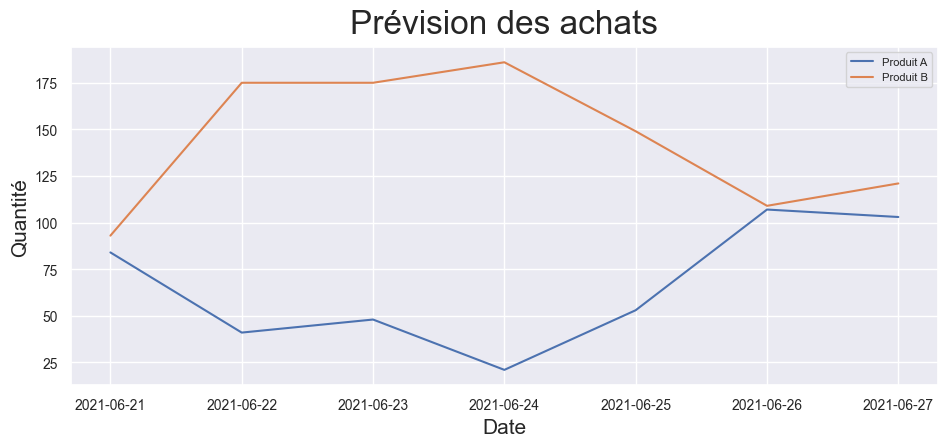

In [219]:
plt.figure(figsize=(10,5))
sns.lineplot(data=sales_forecast, x="date", y="item_A", label="Produit A" )
sns.lineplot(data=sales_forecast, x="date", y="item_B", label = "Produit B")
plt.title("Prévision des achats", pad=10)
plt.xlabel("Date", size = 15)
plt.ylabel("Quantité", size=15)
plt.tick_params(axis = 'both', labelsize = 10)
plt.tight_layout()
plt.legend(prop={'size': 8})
plt.show()
plt.close()

**Observation**<br>
On retrouve bien la saisonnalité des produits sur juin.

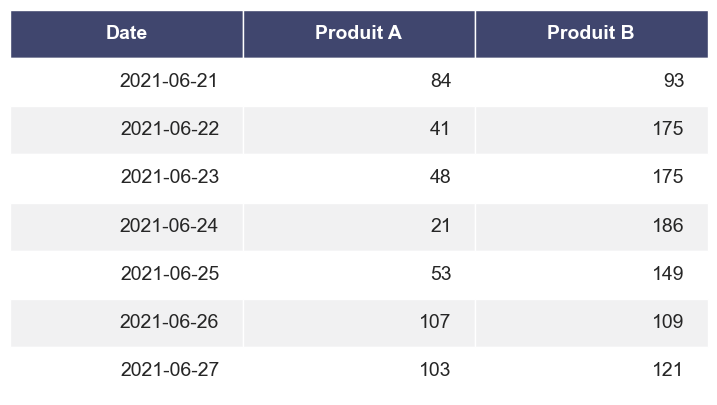

In [235]:
colLabels=["Date","Produit A","Produit B"]
render_mpl_table(sales_forecast,title="foreacst_sales",colLabels=colLabels)
